# Explore VAE on CMIP data

The notebook explores the properties of the Variational Autoencoder (VAE) trained on CMIP5 data. The key steps and components involved are outlined as follows:

1. The configuration parameters of the model are loaded from the `LOG_DIR` folder.

2. The VAE model consists of four components: _encoder_, _latent sampling_, _decoder_, and a _second decoder for prediction_. Separate model instances are created for each component:
    * _Encoder_: The encoder takes a sample `x` and returns the mean `z_mean` and logarithmic variance `z_log_var` of the latent variable `z`.
    * _Latent Sampling_: The latent sampling takes `z_mean` and `z_log_var` as inputs and generates a random latent sample `z`.
    * _Decoder_: The decoder reconstructs the input `x` by taking the latent sample `z` and producing the decoded output `y`. 
   * _Decoder for Prediction_: The second decoder also takes the latent sample `z` but generates a prediction output.
   
3. The model weights from the training process are loaded from the `LOG_DIR` folder.
   
4. CMIP5 and observational data is loaded.

5. Properties of the `encoder` and `decoder` are analyzed.

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import glob
import os
import random
from types import SimpleNamespace

import numpy as np
import pandas as pd
import yaml
from IPython.display import display
from matplotlib import colors as mcolors
from matplotlib import dates, path
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import interpolate, signal, stats
from sklearn.neighbors import KNeighborsRegressor
from tqdm.notebook import tqdm

In [3]:
from tensorflow import get_logger
from tensorflow.compat.v1 import disable_eager_execution, disable_v2_behavior

get_logger().setLevel('ERROR')
disable_eager_execution()
disable_v2_behavior()

In [4]:
from VAE import generators, models
from VAE.utils import fileio
from VAE.utils import plot as vplt

In [5]:
FIGWIDTH = 16
VERBOSE = 0
EXPORT = False  # export figures as pdf
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
plt.rcParams['figure.figsize'] = (FIGWIDTH, 0.3 * FIGWIDTH)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 75
np.set_printoptions(formatter={'float_kind': lambda x: f'{x: .3f}'}, linewidth=120)

## Parameters

We load the configuration from the the folder `LOG_DIR`. 

In [6]:
EPOCH = 15
LOG_DIR = r'logs/2022-10-28T19.45'
MODEL_FILE = f'model.{EPOCH:02d}.h5'

In [7]:
print('LOG_DIR    :', LOG_DIR)
print('MODEL_FILE :', MODEL_FILE)

LOG_DIR    : logs/2022-10-28T19.45
MODEL_FILE : model.15.h5


First let's load the parameters from the model training in `trainer_config.yaml`.

In [8]:
fn = os.path.join(LOG_DIR, 'trainer_config.yaml')
with open(fn, 'r') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

assert params['model'].get('__version__') == models.__version__, 'Model version mismatch.'
assert params['fit_generator'].get('__version__') == generators.__version__, 'Generator version mismatch.'

params = SimpleNamespace(**params)

Make some modifications to the parameters at inference time. 

In [9]:
params.model['beta'] = 1.
params.fit_generator['shuffle'] = False
params.fit_generator2['repeat_samples'] = 30

## Model

The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component.

### Encoder

The encoder takes a sample `x` and returns `z_mean` and `z_log_var`:

In [10]:
encoder = models.Encoder(**params.model, name='encoder')

### Latent sampling

The latent sampling takes the two inputs `z_mean` and `z_log_var` and returns a set of `set_size=1` random latent sample `z`:

In [11]:
latent_sampling = models.LatentSampling(**params.model, name='latent')

### Decoder

The decoder, finally, takes a latent sample `z` and returns a reconstruction of input `x`. The decoding works backward in time and we set `output_reverse=True` so that the order of decoder output matches the input to the encoder.

In [12]:
decoder = models.Decoder(output_shape=params.model.get('input_shape'),
                         decoder_blocks=params.model.get('encoder_blocks'),
                         output_reverse=True,
                         **params.model,
                         name='decoder')

### Decoder for prediction

Like the decoder, the second decoder takes a same latent sample `z` and its output will provide predictions of `x`. In contrast to the `decoder`, we set `output_reverse=False` so that the output of `prediction` is forward in time.

In [13]:
prediction = models.Decoder(output_shape=params.model.get('prediction_shape'),
                            decoder_blocks=params.model.get('encoder_blocks'),
                            output_reverse=False,
                            **{
                                **params.model,
                                **params.prediction
                            },
                            name='prediction')

### Full model

Now that we have the four components, we a ready to create the full model.

In [14]:
model = models.VAEp(encoder, decoder, latent_sampling, prediction, **params.model)

Let's plot the model.

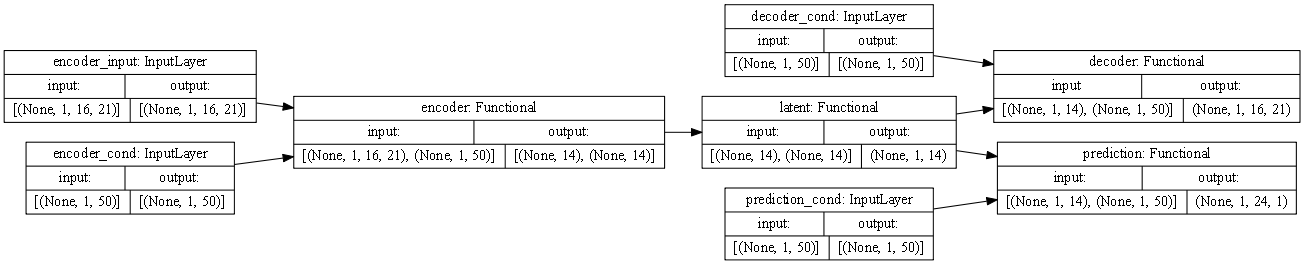

In [15]:
models.ks.utils.plot_model(model, show_shapes=True, dpi=75, rankdir='LR')

The following table summarizes the number of model parameters for each of the components.

In [16]:
model.summary(line_length=120)

Model: "mVAEp"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
encoder_input (InputLayer)             [(None, 1, 16, 21)]        0                                                     
________________________________________________________________________________________________________________________
encoder_cond (InputLayer)              [(None, 1, 50)]            0                                                     
________________________________________________________________________________________________________________________
encoder (Functional)                   [(None, 14), (None, 14)]   61606         encoder_input[0][0]                     
                                                                                encoder_cond[0][0]                      
_________________

### Load model weights

We load the model weights from the training.

In [17]:
fn = os.path.join(LOG_DIR, MODEL_FILE)
model.load_weights(fn, by_name=True)
print('Load model weights from:', os.path.normpath(fn))

Load model weights from: logs\2022-10-28T19.45\model.15.h5


## Load data

### CMIP5 data

First we load the CMIP5 data.

In [18]:
pc_scale = params.data.pop('pc_scale', 1)
dataframe, metadata = fileio.read_climexp_raw_data_multi(**params.data, join='inner', dtype='float32')
time = dataframe.index.to_numpy()
titles = [metadata[key].get('description') for key in dataframe.columns.levels[0]]

We stack the data of the different files along the last axis, the channels. We restrict the number of data channels to the number of input channels of the model.

In [19]:
data = np.stack([dataframe[name].T for name in dataframe.columns.levels[0]], axis=-1)
data = data[..., :params.model['input_shape'][-1]]
print('data shape (runs, time, channels) :', data.shape)

data shape (runs, time, channels) : (38, 1692, 21)


We read the names of the models.

In [20]:
path = os.path.commonpath([os.path.dirname(p) for p in params.data['filename']])
filename = glob.glob(os.path.join(path, '*names*.csv'))[0]
print('Read model names from:', os.path.normpath(filename))
with open(filename) as file:
    data_names = file.read().split('\n')
    data_names = [name.split()[1] for name in data_names]

Read model names from: data\rcp45\icmip5_tos_Omon_one_rcp45_names.csv


We normalize the PCs so that their total variance matches that of the ENSO index (assumed to be the leading channel).

In [21]:
pc_idx = [title.startswith('PC') for title in titles]
pc_idx = np.array(pc_idx)[:params.model['input_shape'][-1]]
print('data is PC: ', pc_idx)

data is PC:  [False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [22]:
if np.any(pc_idx):
    data_var = np.var(data, axis=(0, 1))
    pc_scales = (data_var[0] / data_var[pc_idx] / sum(pc_idx))**0.5
    pc_scales *= pc_scale**0.5

    data[..., pc_idx] *= pc_scales
    print(f'PC scale: {pc_scales}')

PC scale: [ 5.659  9.483  19.491  23.611  18.818  29.054  31.534  24.295  45.947  24.783  17.199  29.809  44.323  54.509  33.797
  42.890  34.887  39.952  40.214  45.211]


Mean and variance of the CMIP data.

In [23]:
axis = (0, 1)
print(f'Mean     : {np.mean(data, axis=axis)} ={np.mean(data): .3f}')
print(f'Variance : {np.var(data, axis=axis)} ={np.var(data): .3f}')

Mean     : [ 0.000  0.000 -0.000 -0.000 -0.000  0.000  0.000 -0.000 -0.000 -0.000  0.000 -0.000 -0.000  0.000  0.000  0.000 -0.000
 -0.000 -0.000 -0.000 -0.000] = 0.000
Variance : [ 0.752  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188
  0.188  0.188  0.188  0.188] = 0.215


We split the CMIP5 ensemble runs into separate datasets and shuffle the different runs.

In [24]:
dataset = np.split(data, len(data), axis=0)
c = list(zip(dataset, data_names))
random.seed(params.fit_generator.get('validation_seed', None))
random.shuffle(c)
dataset, dataset_names = zip(*c)

print('Shape of datasets  :', dataset[0].shape)
print('Number of datasets :', len(dataset))

Shape of datasets  : (1, 1692, 21)
Number of datasets : 38


We split the datasets into a set for training and a set for validation.

In [25]:
validation_split = int(len(dataset) * params.fit_generator['validation_split'])
print('Number of training datasets   :', validation_split)
print('Number of validation datasets :', len(dataset) - validation_split)

Number of training datasets   : 38
Number of validation datasets : 0


### Observational data

Next, we load the observational data.

In [26]:
dataframe2, metadata2 = fileio.read_climexp_raw_data_multi(**{
    **params.data,
    **params.data2
},
                                                           join='inner',
                                                           dtype='float32')
time2 = dataframe2.index.to_numpy().astype('datetime64[M]')
titles2 = [metadata2[key].get('description') for key in dataframe2.columns.levels[0]]

We stack the data of the different files along the last axis, the channels.  We restrict the number of data channels to the number of input channels of the model.

In [27]:
data2 = np.stack([dataframe2[name].T for name in dataframe2.columns.levels[0]], axis=-1)
data2 = data2[..., :params.model['input_shape'][-1]]
print('Shape of dataset :', data2.shape)

Shape of dataset : (1, 1884, 21)


We scale the PCs by the same factor as the CMIP data above.

In [28]:
if np.any(pc_idx):
    data2[..., pc_idx] *= pc_scales

Furthermore, we obtain the climatological mean of the data wrt to 1971-2000, for later use in the figures.

In [29]:
idx = (np.datetime64('1971') <= time2) & (time2 <= np.datetime64('2000'))
data2_offset = np.mean(data2[:, idx, :], axis=1)

### EOFs

We also read the EOFs that correspond to the PCs in the data.

In [30]:
path = [p for p in params.data['filename'] if 'pcs' in p][0]
path = os.path.dirname(path)
filename = glob.glob(os.path.join(path, '*eofs*.nc'))[0]
eofs, eof_dims, eof_attrs = fileio.read_netcdf(filename, dtype='float32')
print('Read EOFs from', os.path.normpath(filename))

Read EOFs from data\rcp45\pcs_55S60N_5dgr_1865-2005\icmip5_tos_Omon_one_rcp45_eofs.nc


We resample the EOFs at a higher spatial resolution.

In [31]:
longitude = np.arange(0, 360, 1)
latitude = np.arange(eof_dims['lat'][0], eof_dims['lat'][-1], 1)
ieofs = dict()
for key, eof in eofs.items():
    eof_mask = np.isnan(eof)
    eof[eof_mask] = 0
    ieof = interpolate.interp2d(eof_dims['lon'], eof_dims['lat'], np.squeeze(eof), kind='cubic')(longitude, latitude)
    ieof_mask = interpolate.interp2d(eof_dims['lon'], eof_dims['lat'], eof_mask)(longitude, latitude) > 0.5
    ieof[ieof_mask] = np.nan
    ieofs[key] = ieof.astype(eof.dtype)

We stack the EOFs in the order of the PCs

In [32]:
pc_labels = np.array([ti.split()[0] for ti in titles2])[pc_idx]
ieof_stack = np.stack([ieofs[label] for label in pc_labels], axis=0)
ieof_stack = np.squeeze(ieof_stack)
print('Shape of EOFs:', ieof_stack.shape)

Shape of EOFs: (20, 110, 360)


### Plot data

In the following, we compare the CMIP ensemble with the observational data.

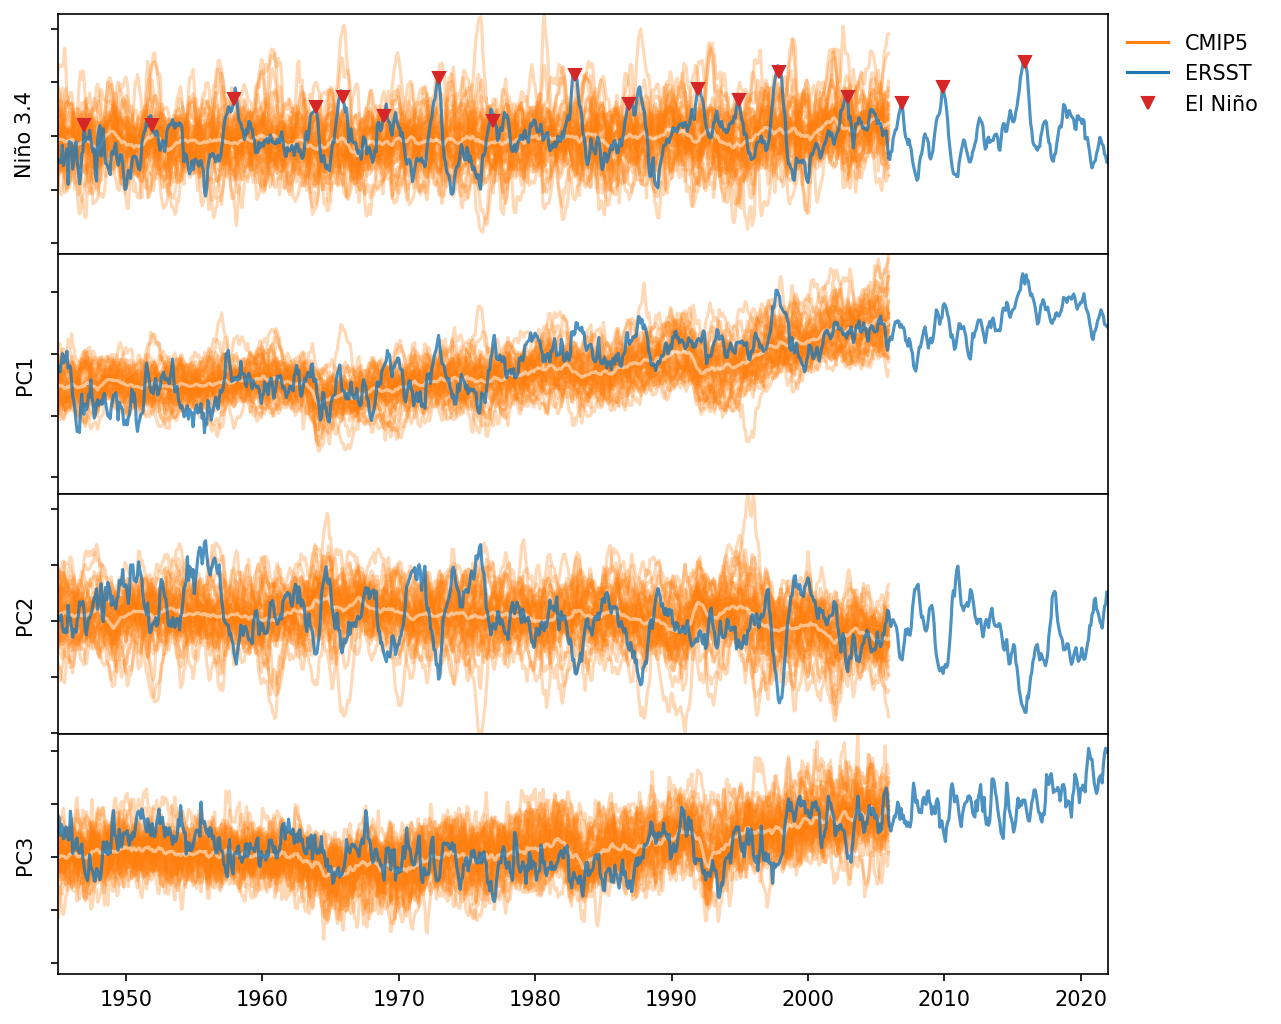

In [33]:
cols = 1
rows = 4

nino_events = [1972, 1976, 1982, 1986, 1997, 2006, 2015]  # EP from Timmermann et al. (2018)
nino_events += [1968, 1994, 2009]  # CP
nino_events += [1965, 1991, 2002]  # mixed
# unclassified from http://www.bom.gov.au/climate/history/enso/
nino_events += [1963, 1957, 1951, 1946, 1941, 1940, 1925, 1919]
nino_events_idx = np.array([np.searchsorted(time2, np.datetime64(f'{event}-12')) for event in nino_events])

nina_events = [1924, 1928, 1938, 1950, 1954, 1964, 1970, 1973, 1988, 1995, 1998, 2007,
               2010]  # from https://www.pmel.noaa.gov/elnino/lanina-faq
nina_events_idx = np.array([np.searchsorted(time2, np.datetime64(f'{event}-12')) for event in nina_events])

idx = (np.datetime64('1971') <= time2) & (time2 <= np.datetime64('2000'))
scale = 2 if cols == 1 else 1
fig, axs = plt.subplots(rows,
                        cols,
                        sharex=True,
                        sharey=False,
                        figsize=(FIGWIDTH * cols / scale, FIGWIDTH / 4 / scale * rows),
                        squeeze=False)
fig.subplots_adjust(left=0.075, right=0.95, bottom=0.1, top=0.9, hspace=0.0)
for ax, da, da2, title, title2, ispc in zip(axs.flat, data.T, data2.T, titles, titles2, pc_idx):
    da2_offset = np.mean(da2[idx])
    da_mean = np.mean(da, axis=1)
    p1, *_ = ax.plot(time, da - da2_offset, color='tab:orange', alpha=0.3, zorder=2)
    p1b, = ax.plot(time, da_mean - da2_offset, color='w', alpha=0.5, zorder=2.1)
    p2, = ax.plot(time2, da2 - da2_offset, color='tab:blue', alpha=0.8, zorder=2.2)
    ax.margins(y=0)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    if not ispc:
        p3, = ax.plot(time2[nino_events_idx],
                      da2[nino_events_idx] - da2_offset,
                      'v',
                      color='tab:red',
                      zorder=2.2,
                      label='El Niño')
        lh = ax.legend((p1, p2, p3), ('CMIP5', 'ERSST', 'El Niño'),
                       frameon=False,
                       loc='upper left',
                       bbox_to_anchor=(1, 1))
        for lh in lh.legendHandles:
            lh.set_alpha(1)
        ax.set_ylabel('Niño 3.4')
    else:
        ax.set_ylabel(title.split()[0])

ax.set_xlim([np.datetime64('1945'), np.datetime64('2022')]);

## Generators

### Fit generator

We create a generator that takes CMIP data as input, such as in the model pre-training.

In [34]:
month = time.astype('datetime64[M]').astype(int)
fit_gen = generators.FitGenerator(dataset, time=month, **params.fit_generator)
fit_gen.summary()

Number of datasets : 38
Total data size    : 1,350,216
Total data length  : 64,296
Strides            : 1
Number of samples  : 62,814
Batch size         : 128
Number of batches  : 491
Sample repetitions : 5
Actual batch size  : 128 * 5 = 640
Shuffle            : False
Filter length
  input      : 0
  prediction : 1
Ensemble condition
  size : 38
  type : index
Input channels     : all
Predicted channels : (0,)
Output shapes
  inputs
    encoder_input    : (640, 1, 16, 21)
    encoder_cond     : (640, 1, 50)
    decoder_cond     : (640, 1, 50)
    prediction_cond  : (640, 1, 50)
  targets
    decoder          : (640, 1, 16, 21)
    prediction       : (640, 1, 24, 1)


### Reference generator

For reference, we also create a generator for the observational data.

In [35]:
month2 = time2.astype('datetime64[M]').astype(int)

In [36]:
ref_gen = generators.FitGenerator(data2, time=month2, **{**params.fit_generator, **params.fit_generator2})
ref_gen.summary()

Number of datasets : 1
Total data size    : 39,564
Total data length  : 1,884
Strides            : 1
Number of samples  : 1,845
Batch size         : 32
Number of batches  : 58
Sample repetitions : 30
Actual batch size  : 32 * 30 = 960
Shuffle            : False
Filter length
  input      : 0
  prediction : 1
Ensemble condition
  size : 38
  type : random
  range   : (0, 38)
  sync    : True
  replace : False
Input channels     : all
Predicted channels : (0,)
Output shapes
  inputs
    encoder_input    : (960, 1, 16, 21)
    encoder_cond     : (960, 1, 50)
    decoder_cond     : (960, 1, 50)
    prediction_cond  : (960, 1, 50)
  targets
    decoder          : (960, 1, 16, 21)
    prediction       : (960, 1, 24, 1)


## Latent space

### KL divergence

The module `VAE.utils.plot` provides multiple functions to plot and analyze properties of the `encoder` and the `decoder`. First let's start with the `encoder` and explore properties of the latent space.

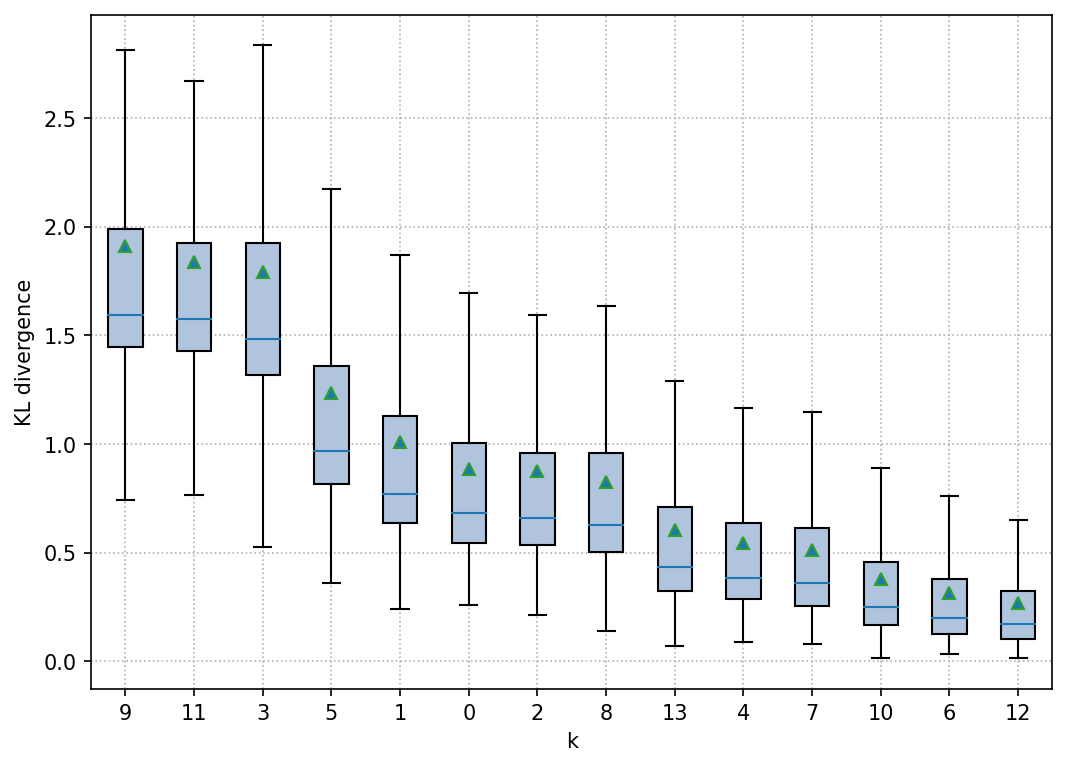

In [37]:
fig = plt.figure(0, figsize=(7, 5))
fig, ax, z_order, kl_div = vplt.encoder_boxplot(encoder, fit_gen, plottype='kl', name=0, verbose=VERBOSE)

The plot shows the KL divergence of the latent variables for each of the latent dimension separately. The dimensions are sorted in descending order of the KL divergence. Latent dimensions with a high KL divergence are more important for the later reconstruction with the decoder. Latent dimensions that have a KL divergence close to zero are unused dimensions; i.e. they are practically not important for the reconstruction.

In [38]:
active_units = np.sum(np.mean(kl_div, axis=0) > 0.1)
print('Active units:', active_units)
active_units = min(6, active_units)

Active units: 14


The function `encoder_boxplot` also returns a sequence `z_order`, the order of the latent dimensions, which we will retain the most important dimensions for the other plots as well.

### Histograms

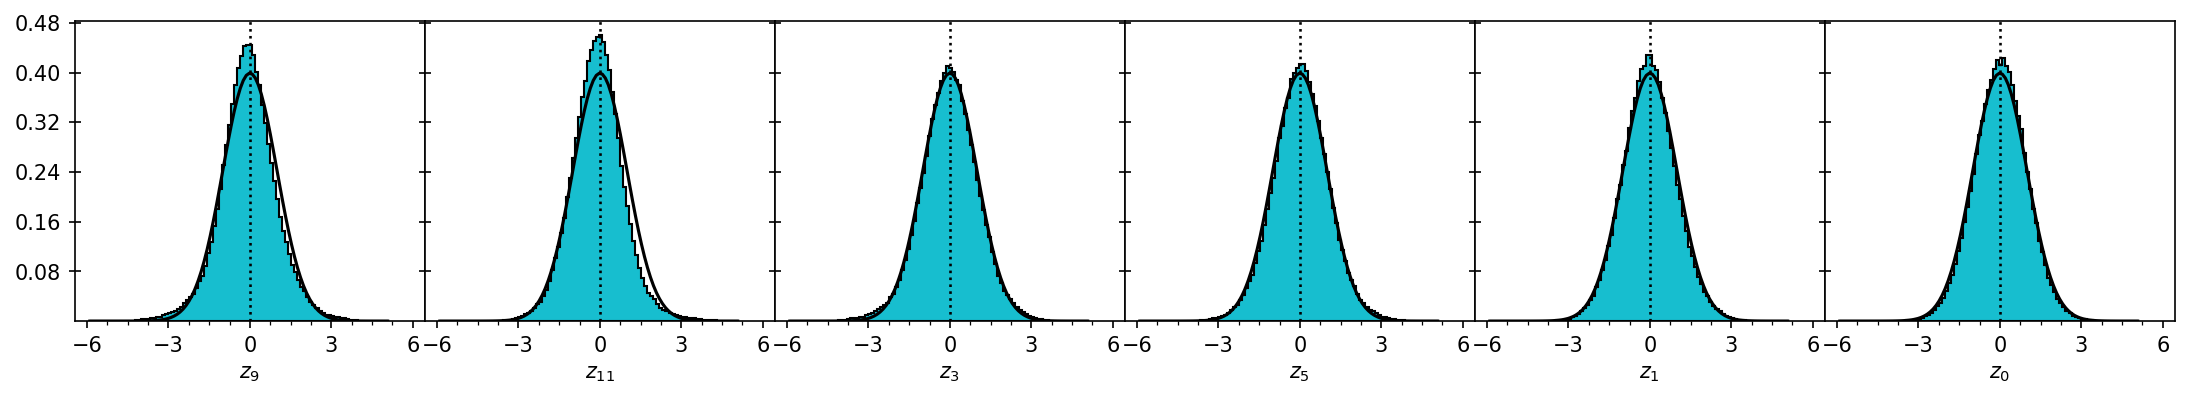

In [39]:
fig = plt.figure(0, figsize=(FIGWIDTH, 2.5))
fig, axs = vplt.encoder_hist(encoder,
                             fit_gen,
                             latent_sampling=latent_sampling,
                             order=z_order[:active_units],
                             bins=100,
                             name=0,
                             verbose=VERBOSE)

The plot compares the histograms of latent samples obtained from the dataset, the so-called __aggregated posterior__ (cyan) with the prior distribution (black curve).

### Latent variables

#### CMIP5

We get the latent variables for the CMIP5 data.

In [40]:
z_mean, z_log_var = encoder.predict(fit_gen, verbose=VERBOSE)
z_sample = latent_sampling.predict([z_mean, z_log_var])
z_sample = np.squeeze(z_sample)

We reshape the latent samples in order to separate them for each dataset into different slices along the first axis.

In [41]:
z_sample_r = np.reshape(z_sample, (len(dataset), -1) + z_sample.shape[1:])
print('Shape of z_sample_r:', z_sample_r.shape)

Shape of z_sample_r: (38, 8265, 14)


In [42]:
time_idx = np.concatenate([fit_gen.get_index(n)[:, 1] for n in range(len(fit_gen))])
time_idx = np.reshape(time_idx, (len(dataset), -1))
target_time = time[time_idx]
target_time.shape

(38, 8265)

In [43]:
k_trend = params.__dict__.get('_notes', {}).get('k_trend')
k_pair = params.__dict__.get('_notes', {}).get('k_pair', z_order[[0, 1]])
k_pair = tuple(k_pair)
print(f'Trend component : {k_trend}')
print(f'Oscillatory mode: {k_pair}')

Trend component : None
Oscillatory mode: (9, 11)


In [44]:
k0, k1 = k_pair

#### ERSST

For comparison, we get the latent variables for the observational data.

In [45]:
z2_mean, z2_log_var = encoder.predict(ref_gen, verbose=VERBOSE)
z2_sample = latent_sampling.predict([z2_mean, z2_log_var])
z2_sample = np.squeeze(z2_sample)

time_idx2 = np.concatenate([ref_gen.get_index(n)[:, 1] for n in range(len(ref_gen))])
target_time2 = time2[time_idx2]

# average z over random ensemble conditions
r = params.fit_generator2['repeat_samples']
z0_ref = np.reshape(z2_sample[:, k0], (-1, r))
z1_ref = np.reshape(z2_sample[:, k1], (-1, r))
z0_ref_mean = z0_ref.mean(axis=-1)
z1_ref_mean = z1_ref.mean(axis=-1)
nino_events_idx = np.array([np.searchsorted(target_time2[::r], np.datetime64(f'{event}-12')) for event in nino_events])
nina_events_idx = np.array([np.searchsorted(target_time2[::r], np.datetime64(f'{event}-12')) for event in nina_events])

z0_ref_diff = signal.savgol_filter(z0_ref, window_length=5, polyorder=1, deriv=1, axis=0)
z1_ref_diff = signal.savgol_filter(z1_ref, window_length=5, polyorder=1, deriv=1, axis=0)
bins = 22 * 5
xi = np.linspace(-5.5, 5.5, bins + 1)
yi = np.linspace(-5.5, 5.5, bins + 1)
s = 5

v12_ref, x12, y12, _ = stats.binned_statistic_2d(z0_ref.flatten(),
                                                 z1_ref.flatten(),
                                                 [z0_ref_diff.flatten(), z1_ref_diff.flatten()],
                                                 bins=(xi[::s], yi[::s]))
v12_ref_abs = (v12_ref[0]**2 + v12_ref[1]**2)**0.5
xim_ref = (x12[:-1] + x12[1:]) / 2
yim_ref = (y12[:-1] + y12[1:]) / 2
v12_ref_rel = v12_ref_abs / (2 * np.pi * (xim_ref[None, :]**2 + yim_ref[:, None]**2)**0.5) * 12

### Phase-space dynamics

In the following, we analyze the phase-space dynamics of the VAE.

In [46]:
r = params.model['repeat_samples']
z0_all = np.reshape(z_sample_r[..., k0], (len(dataset), -1, r))
z1_all = np.reshape(z_sample_r[..., k1], (len(dataset), -1, r))

z0_all_diff = signal.savgol_filter(z0_all, window_length=5, polyorder=2, deriv=1, axis=1)
z1_all_diff = signal.savgol_filter(z1_all, window_length=5, polyorder=2, deriv=1, axis=1)
bins = 22 * 5
xi = np.linspace(-5.5, 5.5, bins + 1)
yi = np.linspace(-5.5, 5.5, bins + 1)
s = 5

v12_all, x12, y12, _ = stats.binned_statistic_2d(z0_all.flatten(),
                                                 z1_all.flatten(),
                                                 [z0_all_diff.flatten(), z1_all_diff.flatten()],
                                                 bins=(xi[::s], yi[::s]))
v12_all_abs = (v12_all[0]**2 + v12_all[1]**2)**0.5

xim_all = (x12[:-1] + x12[1:]) / 2
yim_all = (y12[:-1] + y12[1:]) / 2

v12_all_rel = v12_all_abs / (2 * np.pi * (xim_all[None, :]**2 + yim_all[:, None]**2)**0.5) * 12

p0, _ = np.histogram(z0_all.flatten(), bins=xi, density=True)
p1, _ = np.histogram(z1_all.flatten(), bins=yi, density=True)
p0_norm = stats.norm.pdf(xi, 0, 1)
p1_norm = stats.norm.pdf(yi, 0, 1)

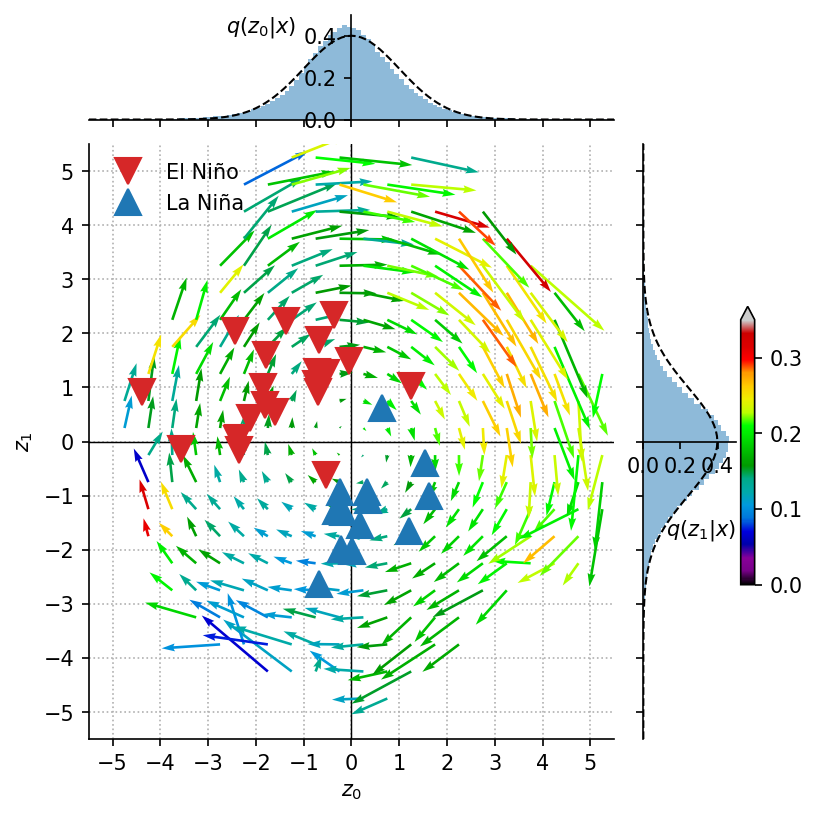

In [47]:
fig, ((uax, _ax), (cax, rax)) = plt.subplots(2,
                                             2,
                                             figsize=(FIGWIDTH / 3, FIGWIDTH / 3),
                                             gridspec_kw={
                                                 'width_ratios': (0.85, 0.15),
                                                 'height_ratios': (0.15, 0.85)
                                             },
                                             sharex='col',
                                             sharey='row')

fig.delaxes(_ax)

vmin, vmax = 0, 0.35
cmap = 'nipy_spectral'

h1 = cax.quiver(xim_all,
                yim_all,
                v12_all[0].T,
                v12_all[1].T,
                v12_all_rel,
                clim=(vmin, vmax),
                cmap=cmap,
                zorder=2.1,
                scale=4.5,
                width=0.005)

h2, = cax.plot(z0_ref_mean[nino_events_idx],
               z1_ref_mean[nino_events_idx],
               'v',
               color='tab:red',
               markersize=FIGWIDTH * 0.8,
               zorder=2.2)

h3, = cax.plot(z0_ref_mean[nina_events_idx],
               z1_ref_mean[nina_events_idx],
               '^',
               color='tab:blue',
               markersize=FIGWIDTH * 0.8,
               zorder=2.2)

cax.legend([h2, h3], ['El Niño', 'La Niña'], loc='upper left', frameon=False)
cax.axhline(0, linestyle='-', color='k', linewidth=0.7)
cax.axvline(0, linestyle='-', color='k', linewidth=0.7)

mp = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(mp, ax=rax, extend='max', shrink=0.75)

r0 = z_order.tolist().index(k0)
r1 = z_order.tolist().index(k1)
cax.set_xlabel(f'$z_{{{r0}}}$')
cax.set_ylabel(f'$z_{{{r1}}}$')
cax.set_xlim(xi[[0, -1]])
cax.set_ylim(yi[[0, -1]])
cax.grid(which='major', axis='both', linestyle=':')
cax.xaxis.set_major_locator(ticker.MultipleLocator(1))
cax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# cax.xaxis.set_major_formatter(ticker.NullFormatter())
# cax.yaxis.set_major_formatter(ticker.NullFormatter())
# cax.xaxis.set_major_locator(ticker.NullLocator())
# cax.yaxis.set_major_locator(ticker.NullLocator())
# cax.set_aspect(aspect=1, adjustable='box')
cax.spines['right'].set_visible(False)
cax.spines['top'].set_visible(False)

uax.bar(xi[:-1], p0, align='edge', width=xi[1] - xi[0], color='tab:blue', alpha=0.5)
uax.plot(xi, p0_norm, color='k', linestyle='--', linewidth=1)

uax.set_ylabel(f'$q(z_{{{r0}}}\|x)$', rotation=0, loc='top', va='top')
uax.set_ylim((0, 0.5))
plt.setp(uax.get_xticklabels(), visible=False)
uax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
uax.spines['left'].set_position(('data', 0))
uax.spines['right'].set_visible(False)
uax.spines['top'].set_visible(False)

rax.barh(yi[:-1], p1, align='edge', height=xi[1] - xi[0], color='tab:blue', alpha=0.5)
rax.plot(p1_norm, yi, color='k', linestyle='--', linewidth=1)

rax.set_xlabel(f'$q(z_{{{r1}}}\|x)$', loc='right', va='top', labelpad=20)
rax.set_xlim((0, 0.5))
rax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.setp(rax.get_yticklabels(), visible=False)
rax.spines['bottom'].set_position(('data', 0))
rax.spines['right'].set_visible(False)
rax.spines['top'].set_visible(False)

# fig.savefig('cmip_phase.pdf', bbox_inches='tight')

Their is a dominant oscillatory ensemble dynamics that emerges when merging the latent variables of all models. For the z-values from ERSST, we see that the majority of the El Nino events cluster in the upper-left part of the phase space and he La Nina events in the lower-right part. The transitions from El Nino to La Nina occur at a higher phase speed than transitions from La Nina to EL Nino.

## Spatio-temporal composites

### Obtain model outputs

We first obtain the model outputs for the training data from `fit_gen`.

In [48]:
xcs = []
ycs = []
z_samples = []
z_means = []
z_log_vars = []
for inputs, targets in tqdm(fit_gen, leave=VERBOSE):
    z_mean, z_log_var = encoder.predict_on_batch(inputs)
    zs = latent_sampling.predict_on_batch([z_mean, z_log_var])

    xc = decoder.predict_on_batch([zs, inputs['decoder_cond']])
    yc = prediction.predict_on_batch([zs, inputs['prediction_cond']])

    xcs.append(xc)
    ycs.append(yc)

    z_samples.append(zs)
    z_means.append(z_mean)
    z_log_vars.append(z_log_var)

  0%|          | 0/491 [00:00<?, ?it/s]

In [49]:
xcs = np.concatenate(xcs)
ycs = np.concatenate(ycs)
z_mean = np.concatenate(z_means)
z_log_var = np.concatenate(z_log_vars)
z_sample = np.concatenate(z_samples)
z_sample = np.squeeze(z_sample)

In [50]:
pcs = xcs[..., pc_idx] / pc_scales
print('Shape of PCs:', pcs.shape)

Shape of PCs: (314070, 1, 16, 20)


There seems to be a scaling issues between the Nino index in channel 0 and the reconstruction of the Nino index by the PCs and EOFs. We correct the PCs of the decoder accordingly.

In [51]:
nino_ref = data[..., 0]
nino_eofs = ieof_stack[:, (-5 <= latitude) & (latitude <= 5), :][:, :, (190 <= longitude) & (longitude <= 240)]
nino_rcs = np.tensordot(data[..., pc_idx] / pc_scales, nino_eofs, axes=1)
nino_rcs = np.mean(nino_rcs, axis=(-2, -1))

pc_correction = np.std(nino_ref) / np.std(nino_rcs)
print(f'PC correction scale: {pc_correction:.5}')

PC correction scale: 12.137


In [52]:
pcs *= pc_correction

### Aggregate outputs

To understand the effect of $z$ on the output of `decoder`, we analyze next the the output of the `decoder` as a function of the oscillatory pair in `z`.

In [53]:
print('Oscillatory pair:', k_pair)

Oscillatory pair: (9, 11)


We consider the ouput of the `decoder` in the Nino 3.4 region (`channel=0`),

In [54]:
channel = 0
lags = slice(-3, None)
x_response = xcs[:, 0, lags, channel].mean(axis=-1)

To obtain a function between the output and the oscillatory pair, we use a k-nearest neighbors regression.

In [55]:
%%time
regression = KNeighborsRegressor(n_neighbors=100).fit(z_sample[:, k_pair], x_response)
z_proj = regression.predict(z_sample[:, k_pair])

CPU times: total: 9.45 s
Wall time: 7.94 s


For strong ENSO events, we define the lower and upper limits:

In [56]:
z_min_s = 1

In [57]:
idx_ps = z_min_s < z_proj
idx_ns = z_proj < -z_min_s

In [58]:
print(f'Average positive response: {np.mean(x_response[idx_ps]):.2f}')
print(f'Average negative response: {np.mean(x_response[idx_ns]):.2f}')

Average positive response: 1.44
Average negative response: -1.40


We likewise define limits for weak ENSO events.

In [59]:
z_min_w = 0.5
z_max_w = 1

idx_pw = (z_min_w < z_proj) & (z_proj < z_max_w)
idx_nw = (-z_max_w < z_proj) & (z_proj < -z_min_w)

All the rest is considered as neutral.

In [60]:
idx_neutral = (-z_min_w < z_proj) & (z_proj < z_min_w)
idx_neutral_p = (0 < z_proj) & (z_proj < z_min_w)
idx_neutral_n = (-z_min_w < z_proj) & (z_proj < 0)

We compare the decoder response with the defined ENSO regions in the latent space of the oscillatory pair.

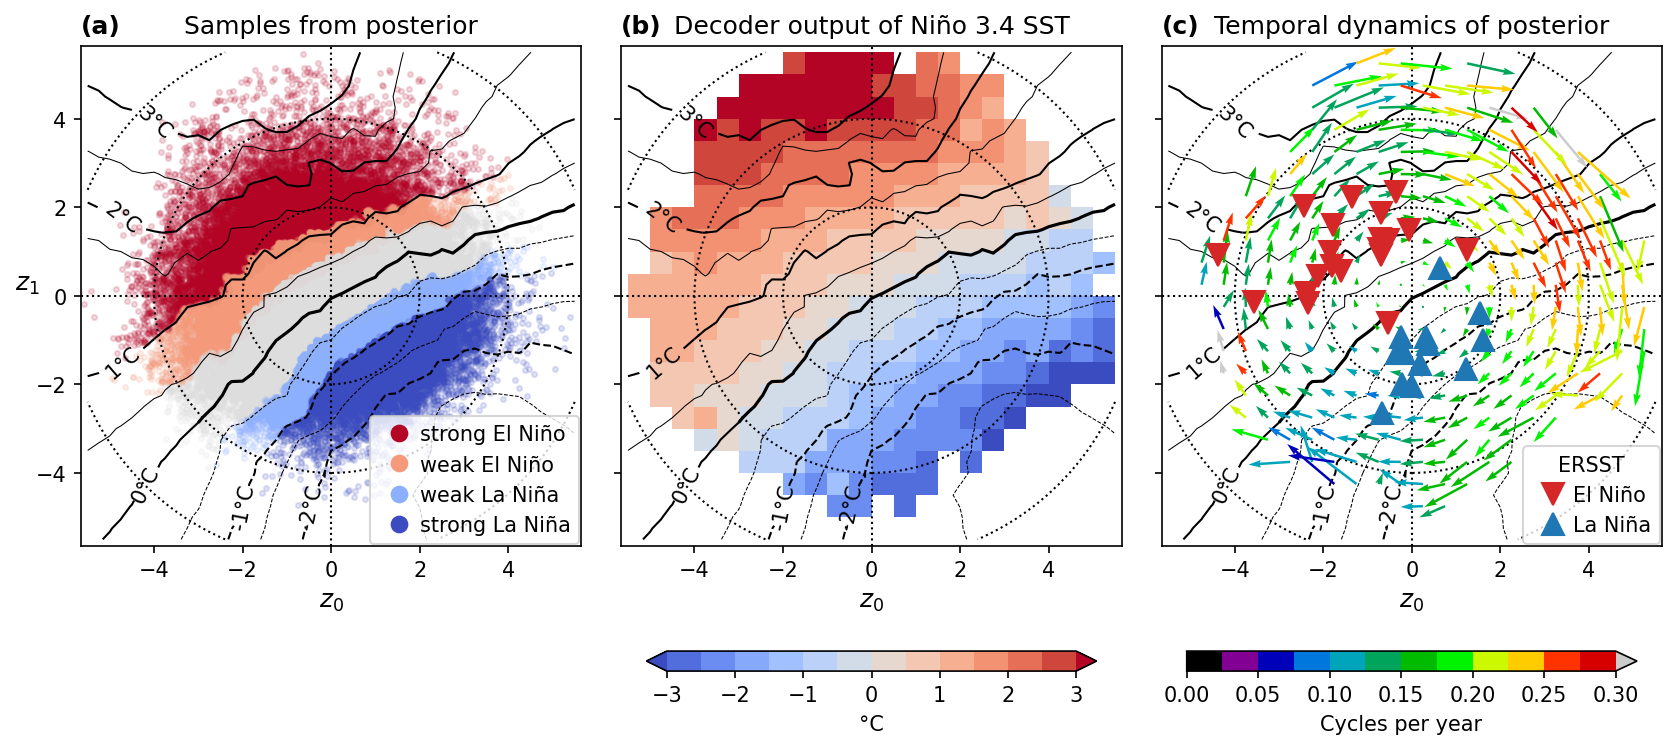

In [61]:
k0, k1 = k_pair

bins = np.arange(-5.5, 5.5 + 0.1, 0.5)
px, *_ = stats.binned_statistic_2d(z_sample[:, k0], z_sample[:, k1], x_response, bins=bins)

xi = np.arange(-5.5, 5.5 + 0.1, 0.25)
xx, yy = np.meshgrid(xi, xi)
zz = regression.predict(np.stack([xx.flat, yy.flat]).T)
zz = zz.reshape(xx.shape)

fig, (rax, cax, lax) = plt.subplots(1,
                                    3,
                                    figsize=(FIGWIDTH * 0.85, FIGWIDTH * 0.85 / 2),
                                    sharex=True,
                                    sharey=True,
                                    gridspec_kw={'wspace': 0.08})
vmin, vmax = 0, 0.3
_cmap = plt.get_cmap('nipy_spectral', 13)
l_cmap = mcolors.ListedColormap([_cmap(c) for c in range(12)])
l_cmap.set_over(_cmap(12))

lax.quiver(xim_all,
           yim_all,
           v12_all[0].T,
           v12_all[1].T,
           v12_all_rel,
           clim=[vmin, vmax],
           cmap=l_cmap,
           zorder=2.1,
           scale=6,
           width=0.005)
h2, = lax.plot(z0_ref_mean[nino_events_idx],
               z1_ref_mean[nino_events_idx],
               'v',
               color='tab:red',
               markersize=11,
               zorder=2.2)
h3, = lax.plot(z0_ref_mean[nina_events_idx],
               z1_ref_mean[nina_events_idx],
               '^',
               color='tab:blue',
               markersize=11,
               zorder=2.2)
lax.legend([h2, h3], ['El Niño', 'La Niña'],
           loc='lower right',
           title='ERSST',
           frameon=True,
           handletextpad=0,
           borderaxespad=0.1)

lax.set_title('Temporal dynamics of posterior')
mp = plt.cm.ScalarMappable(cmap=l_cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
lbax = lax.inset_axes([0.05, -0.25, 0.9, 0.04])
plt.colorbar(mp, ax=lax, cax=lbax, extend='max', label='Cycles per year', orientation='horizontal')

vmax = 3
_cmap = plt.get_cmap('coolwarm', 2 * vmax // 0.5 + 2)
cvals = [_cmap(n) for n in range(1, _cmap.N - 1)]
cmap = mcolors.ListedColormap(cvals)
cmap.set_under(_cmap(0))
cmap.set_over(_cmap(_cmap.N - 1))
mp = cax.pcolormesh(bins, bins, px.T, cmap=cmap, vmin=-vmax, vmax=vmax)
cax.set_title('Decoder output of Niño 3.4 SST')
cbax = cax.inset_axes([0.05, -0.25, 0.9, 0.04])
cb = fig.colorbar(mp, ax=cax, cax=cbax, extend='both', label='°C', orientation='horizontal')

r_cmap = plt.get_cmap('coolwarm_r', 5)
r_colors = [r_cmap(n) for n in range(5)]
for idx, color, label in zip((idx_ps, idx_pw, idx_neutral, idx_nw, idx_ns), r_colors,
                             ('strong El Niño', 'weak El Niño', None, 'weak La Niña', 'strong La Niña')):
    rax.plot(z_sample[idx, k0],
             z_sample[idx, k1],
             '.',
             color=color,
             label=label,
             markersize=5,
             zorder=1,
             alpha=0.15,
             rasterized=True)
ldg = rax.legend(markerscale=3, loc='lower right', frameon=True, handletextpad=0, borderaxespad=0.1)
for lh in ldg.legendHandles:
    try:
        lh._legmarker.set_alpha(1)  # matplotlib <= 3.4
    except:
        lh.set_alpha(1)

rax.set_title('Samples from posterior')

r0 = z_order.tolist().index(k0)
r1 = z_order.tolist().index(k1)
levels = np.arange(-vmax, vmax + 0.1, 0.5)

zz_mask = 1. * (((xi[None, :]**2 + xi[:, None]**2)**0.5 < 4.25) | (xi[None, :] > -0.25))
zz_mask[zz_mask == 0] = np.NaN
zz_mask2 = 1. * (((xi[None, :]**2 + xi[:, None]**2)**0.5 >= 4) & (xi[None, :] <= 0))
zz_mask2[zz_mask2 == 0] = np.NaN

for n, ax in enumerate([rax, cax, lax]):
    cs = ax.contour(xi, xi, zz * zz_mask, levels=levels, colors='k', linewidths=1, negative_linestyles='dashed')
    cs2 = ax.contour(xi, xi, zz * zz_mask2, levels=levels, colors='k', linewidths=1, negative_linestyles='dashed')
    ax.clabel(cs2, levels=cs2.levels[::2], fmt='%1.0f°C')

    for _cs in (cs, cs2):
        for line in _cs.collections[::2]:
            line.set_linewidth(1)
        for line in _cs.collections[1::2]:
            line.set_linewidth(0.5)
        cs.collections[np.searchsorted(_cs._levels, 0)].set_linewidth(1.5)

    ax.set_xlabel(f'$z_{{{r0}}}$', fontsize='large')
    # ax.grid(which='major', axis='both', linestyle=':')
    ax.set_aspect(aspect=1, adjustable='box')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.axhline(0, linestyle=':', color='k', linewidth=1)
    ax.axvline(0, linestyle=':', color='k', linewidth=1)
    ax.contour(xi, xi, (xx**2 + yy**2)**0.5, levels=[2, 4, 6, 8], colors='k', linestyles=':', linewidths=1)
    ax.set_title('(' + chr(ord('a') + n) + ')', fontweight='bold', loc='left')

rax.set_ylabel(f'$z_{{{r1}}}$', rotation=0, fontsize='large')
rax.set_xlim(bins[0] - 0.15, bins[-1] + 0.15)
rax.set_ylim(bins[0] - 0.15, bins[-1] + 0.15)

fig.subplots_adjust()
if EXPORT:
    fig.savefig('latent_space.pdf', bbox_inches='tight', dpi=600)

The plot shows the phase-space regions used to obtain (a) ENSO composites, (b) the decoder output, and (c) the temporal phase-space dynamics. The contourlines show isolines of the k-nearest-neighbor regression of the decoder output onto $z$.

### Composite maps

#### Strong El Niño

We average the response in the PCs over the subset of z-values that are classified as strong El Niño above to obtain PC composites.

In [62]:
pc_ps = np.mean(pcs[idx_ps, 0, ...], axis=0)
print(f'Average over {sum(idx_ps)} out of {len(idx_ps)} samples')

Average over 22287 out of 314070 samples


We obtain corresponding spatio-temporal composites by projecting the PC composites onto the EOFs.

In [63]:
xc_ps = np.tensordot(pc_ps, ieof_stack, axes=(-1, 0))
print('PC shape        :', pc_ps.shape)
print('EOF shape       :', ieof_stack.shape)
print('Resulting shape :', xc_ps.shape)

PC shape        : (16, 20)
EOF shape       : (20, 110, 360)
Resulting shape : (16, 110, 360)


In [64]:
_cmap = plt.cm.get_cmap('RdBu_r', 2 * (8 + 1))
cvals = [_cmap(n) for n in range(1, _cmap.N - 1)]
cmap = mcolors.ListedColormap(cvals)
cmap.set_under(_cmap(0))
cmap.set_over(_cmap(_cmap.N - 1))

kw_args = dict(cmap=cmap,
               figwidth=(FIGWIDTH * 0.25, 4 * 2),
               ncols=1,
               rasterized=True,
               colorbar_kw={
                   'location': 'bottom',
                   'shrink': 0.8,
                   'aspect': 40,
                   'extend': 'both'
               },
               gridlinespec_kw={
                   'draw_labels': True,
                   'linestyle': ':'
               },
               landspec_kw={'facecolor': 'lightgray'},
               projection=vplt.ccrs.LambertCylindrical(central_longitude=-155))

vmax = 1
sl = slice(-16, None, 5)
labels = [f'$\\tau={lag}$ month' for lag in range(-len(xc_ps), 0)][sl]

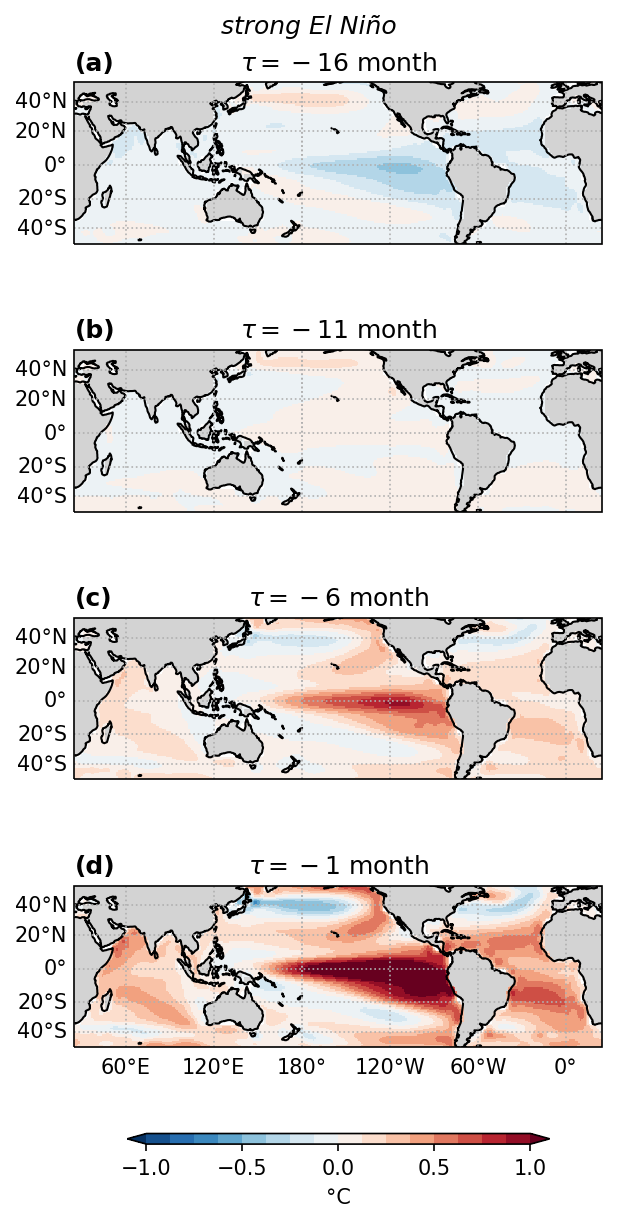

In [65]:
fig, axs, cb = vplt.map_plot(latitude, longitude, xc_ps[sl, ...], labels=labels, vmin=-vmax, vmax=vmax, **kw_args)
cb.set_label('°C', rotation=0, va='top')
fig.suptitle('strong El Niño', fontsize='large', style='italic')
for n, ax in enumerate(axs.flat):
    ax.set_title(f'({chr(ord("a") + n)})', fontweight='bold', loc='left')
    ax.set_aspect('auto')
if EXPORT:
    fig.savefig('composite_strong_nino.pdf', dpi=300)

#### Strong La Niña

We likewise average the PCs over z-values that are classified as strong La Niña.

In [66]:
pc_ns = np.mean(pcs[idx_ns, 0, ...], axis=0)
print(f'Average over {sum(idx_ns)} out of {len(idx_ns)} samples')

Average over 21927 out of 314070 samples


We obtain the spatio-temporal composites by a projection onto the EOFs.

In [67]:
xc_ns = np.tensordot(pc_ns, ieof_stack, axes=(-1, 0))

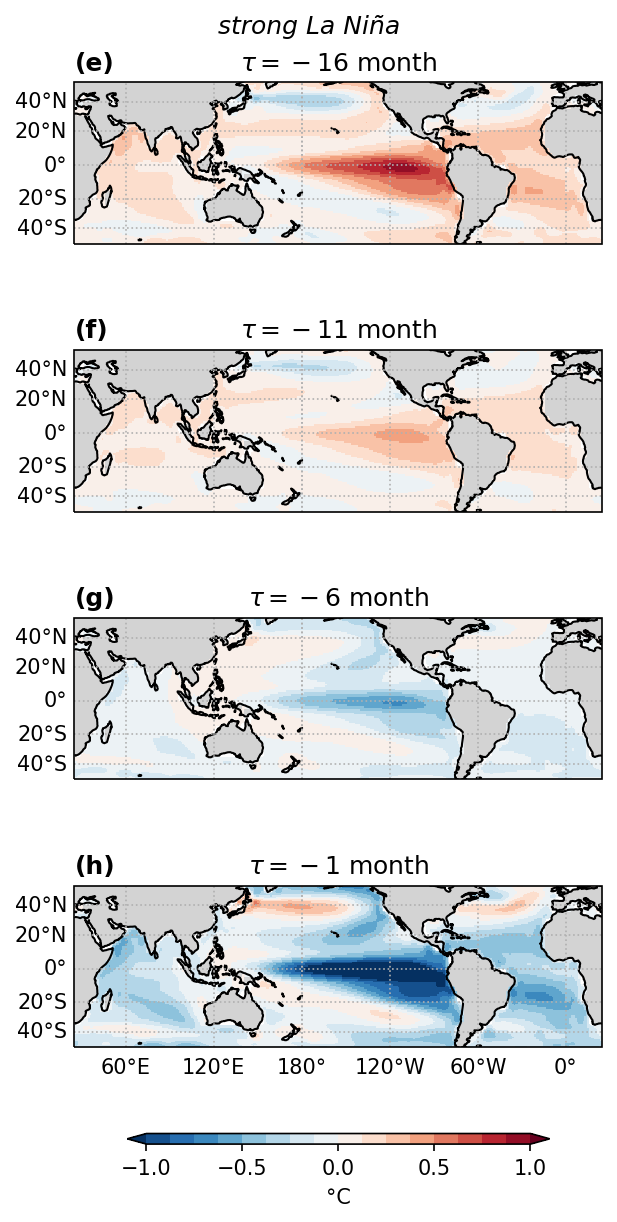

In [68]:
fig, axs, cb = vplt.map_plot(latitude, longitude, xc_ns[sl, ...], labels=labels, vmin=-vmax, vmax=vmax, **kw_args)
cb.set_label('°C', rotation=0, va='top')
fig.suptitle('strong La Niña', fontsize='large', style='italic')
for n, ax in enumerate(axs.flat, start=len(labels)):
    ax.set_title(f'({chr(ord("a") + n)})', fontweight='bold', loc='left')
    ax.set_aspect('auto')
if EXPORT:
    fig.savefig('composite_strong_nina.pdf', dpi=300)

#### Sum of strong ENSO events

To highlight differences between the positive and negative response, we plot the sum of both.

In [69]:
xc_ps_ns = xc_ps + xc_ns

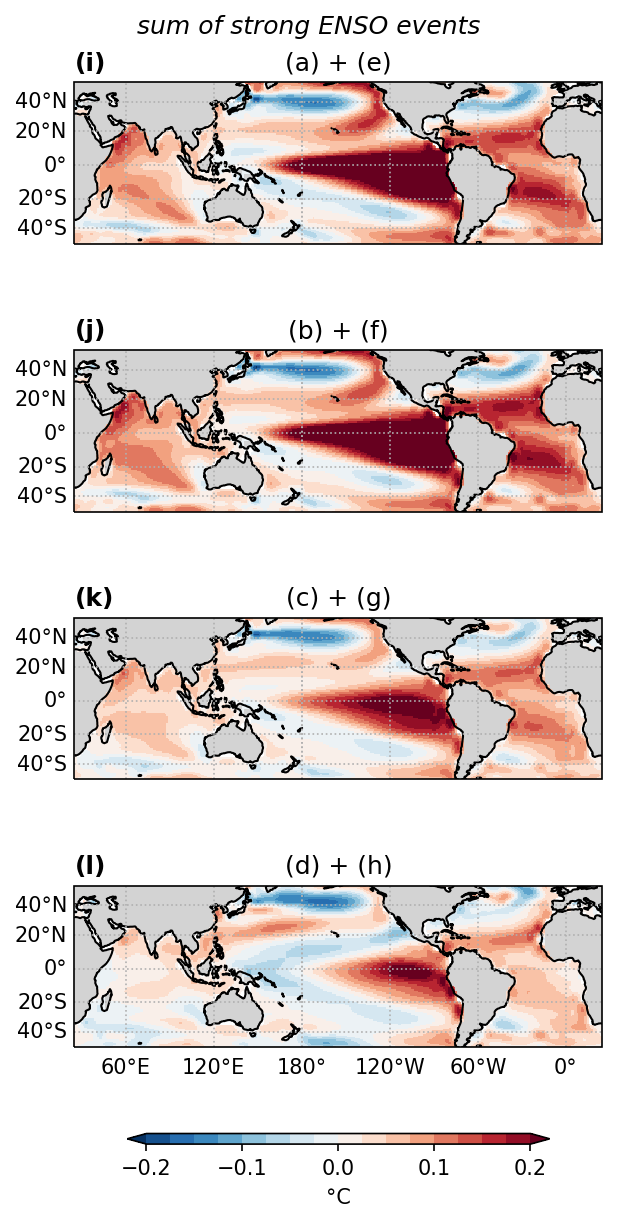

In [70]:
vmax = np.nanpercentile(np.abs(xc_ps_ns), 100)
vmax = 0.2
sum_labels = [f'({chr(ord("a") + n)}) + ({chr(ord("a") + n + len(labels))})' for n in range(len(labels))]
fig, axs, cb = vplt.map_plot(latitude,
                             longitude,
                             xc_ps_ns[sl, ...],
                             labels=sum_labels,
                             vmin=-vmax,
                             vmax=vmax,
                             **kw_args)
cb.set_label('°C', rotation=0, va='top')
fig.suptitle('sum of strong ENSO events', fontsize='large', style='italic')
for n, ax in enumerate(axs.flat, start=2 * len(labels)):
    ax.set_title(f'({chr(ord("a") + n)})', fontweight='bold', loc='left')
    ax.set_aspect('auto')
if EXPORT:
    fig.savefig('composite_strong_sum.pdf', dpi=300)

### Significance maps

We compare reconstructed maps between random sets from `idx1`  and `idx0`, which represent different regions in the latent space. Following the idea of the __Mann–Whitney U test__, we calculate the probability of map values from set `idx1` being larger than that of set `idx0`. Larger values are counted as 1, while smaller values are counted as 0.

In [71]:
def compare_maps(idx1, idx0, n_samples=100, epochs=100, stride=1, confidence=0.90):
    s0 = np.flatnonzero(idx0)
    s1 = np.flatnonzero(idx1)

    total_samples = n_samples * epochs
    rs0 = np.random.choice(s0, total_samples)
    rs1 = np.random.choice(s1, total_samples)
    rs0s = np.split(rs0, epochs)
    rs1s = np.split(rs1, epochs)
    pxc = None
    for rs0, rs1 in tqdm(zip(rs0s, rs1s), total=epochs, leave=False):
        rxc0 = np.tensordot(pcs[rs0, 0, ...], ieof_stack[:, ::stride, ::stride], axes=1)
        rxc1 = np.tensordot(pcs[rs1, 0, ...], ieof_stack[:, ::stride, ::stride], axes=1)
        cmp = rxc0 < rxc1
        if pxc is None:
            pxc = np.sum(cmp, axis=0)
        else:
            pxc += np.sum(cmp, axis=0)

    n = m = total_samples**0.5
    # normal approximation of sum
    ci0, ci1 = stats.norm.interval(confidence, loc=total_samples / 2, scale=(n * m * (n + m + 1) / 12)**0.5)
    if confidence:
        pxc[(ci0 < pxc) & (pxc < ci1)] = total_samples / 2

    pxc = pxc / total_samples
    ci0 = ci0 / total_samples
    ci1 = ci1 / total_samples

    pxc[np.isnan(rxc0[0, ...])] = np.nan

    return pxc, ci0, ci1

#### Strong ENSO events

We compare strong vs weak ENSO events.

##### El Niño events

In [72]:
stride = 1
confidence = 0.95

pxc_ps, ci0, ci1 = compare_maps(idx_ps, idx_pw, stride=stride, confidence=confidence)
print(f'{confidence:.0%} Significance levels: {ci0:.2g}, {ci1:.2g}')

  0%|          | 0/100 [00:00<?, ?it/s]

95% Significance levels: 0.42, 0.58


In [73]:
steps = 0.05
vmin = 0.25
vmax = 0.75
bounds = np.arange(vmin, ci0, steps).tolist() + [ci0, ci1] + np.arange(vmax, ci1, -steps).tolist()[::-1]
norm = mcolors.BoundaryNorm(bounds, ncolors=256, extend='both')
sl = [-16, -11, -6, -3, -1]
labels = [f'$\\tau={lag}$ month' for lag in sl]

kw_args = dict(cmap='RdBu_r',
               figwidth=(FIGWIDTH * 0.85, 2 * 2),
               ncols=3,
               norm=norm,
               rasterized=True,
               colorbar_kw={
                   'orientation': 'horizontal',
                   'shrink': 0.9,
                   'aspect': 10,
                   'extend': 'both',
                   'ticks': bounds,
                   'pad': 0.15,
                   'format': ticker.PercentFormatter(xmax=1, decimals=0, symbol=None)
               },
               gridlinespec_kw={
                   'draw_labels': True,
                   'linestyle': ':'
               },
               landspec_kw={'facecolor': 'lightgray'},
               labels=labels,
               projection=vplt.ccrs.Mercator(central_longitude=-155))

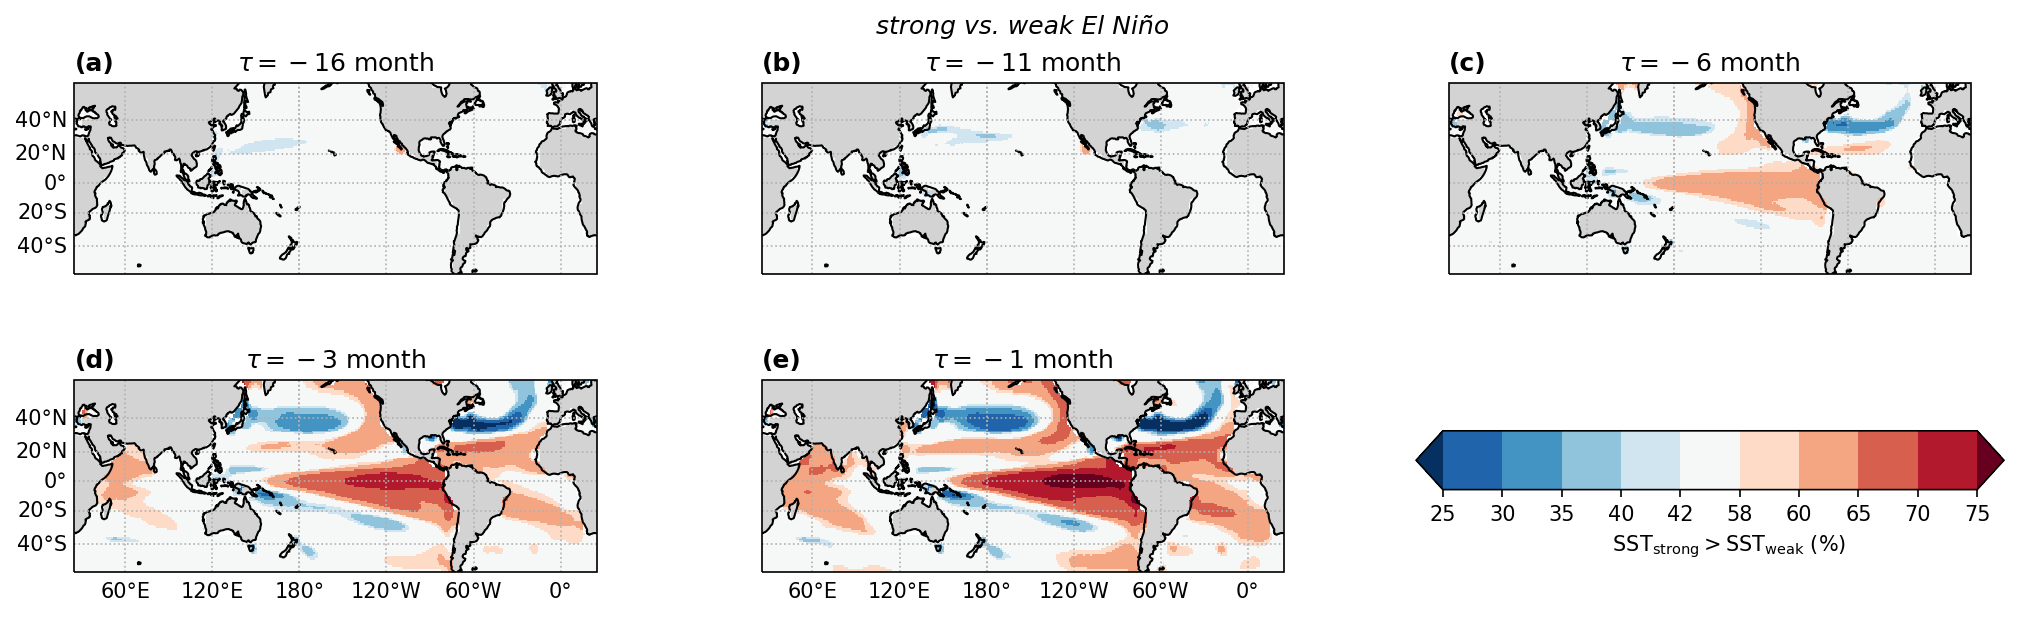

In [74]:
fig, axs, cb = vplt.map_plot(latitude[::stride], longitude[::stride], pxc_ps[sl, ...], **kw_args)
cb.set_label('      $\mathrm{SST}_\mathrm{strong} > \mathrm{SST}_\mathrm{weak}$ (%)')
fig.suptitle('strong vs. weak El Niño', fontsize='large', style='italic')
for n, ax in enumerate(axs.flat):
    ax.set_title(f'({chr(ord("a") + n)})', fontweight='bold', loc='left')
if EXPORT:
    fig.savefig('stats_strong_nino.pdf', dpi=300)

##### La Niña events

In [75]:
pxc_ns, *_ = compare_maps(idx_ns, idx_nw, stride=stride, confidence=confidence)

  0%|          | 0/100 [00:00<?, ?it/s]

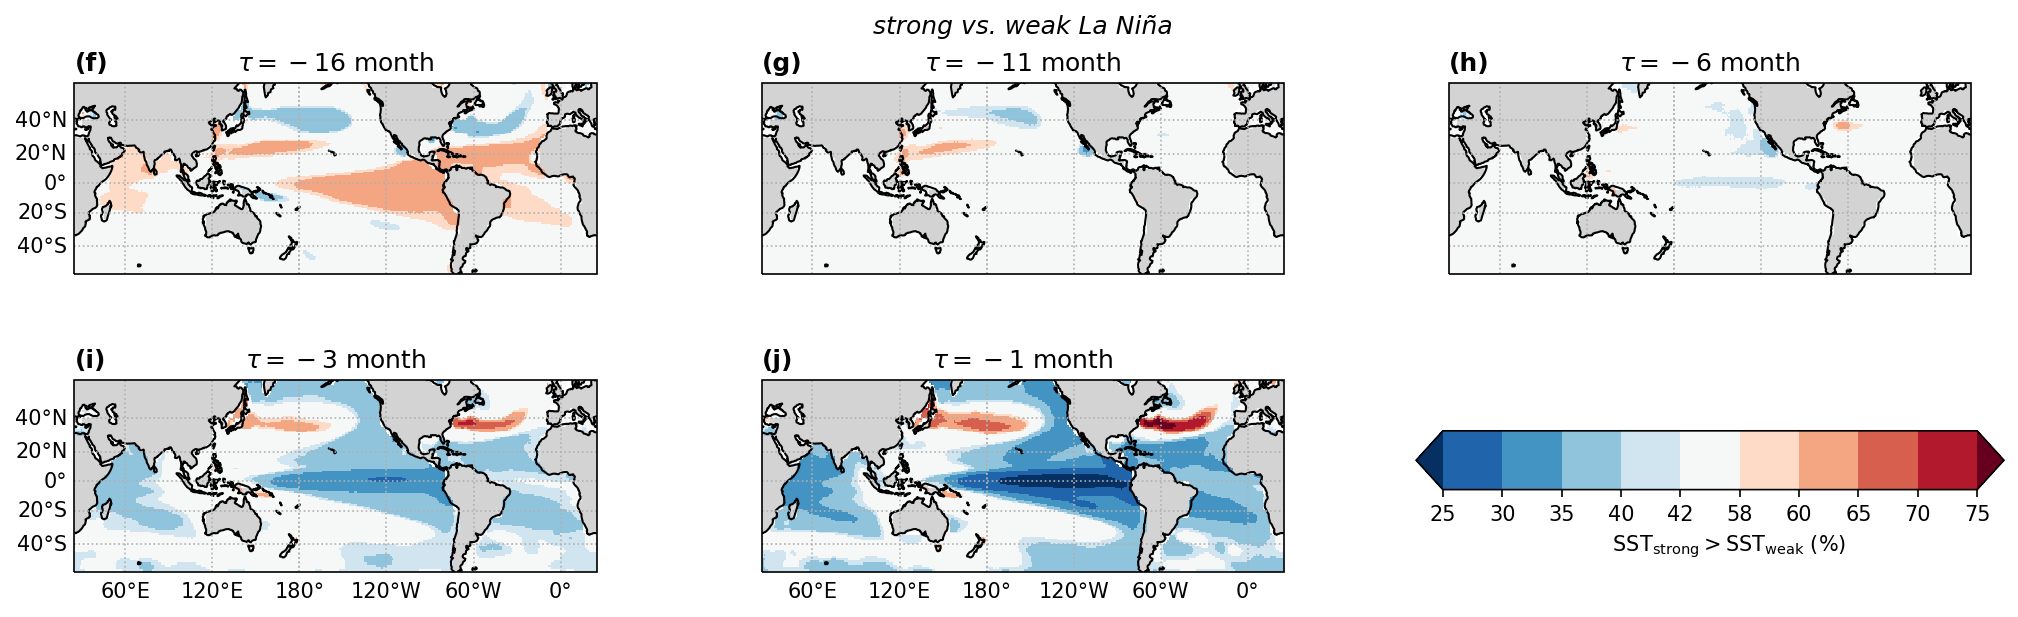

In [76]:
fig, axs, cb = vplt.map_plot(latitude[::stride], longitude[::stride], pxc_ns[sl, ...], **kw_args)
cb.set_label('      $\mathrm{SST}_\mathrm{strong} > \mathrm{SST}_\mathrm{weak}$ (%)')
fig.suptitle('strong vs. weak La Niña', fontsize='large', style='italic')
for n, ax in enumerate(axs.flat, start=len(labels)):
    ax.set_title(f'({chr(ord("a") + n)})', fontweight='bold', loc='left')
if EXPORT:
    fig.savefig('stats_strong_nina.pdf', dpi=300)

#### Strong ENSO events of low KL

We next remove CMIP models from the aggregated posterior that have a high KL for strong ENSO events.

In [77]:
topk = 8

In [78]:
criterion = np.sum(kl_div, axis=-1)
criterion = criterion * (idx_ps | idx_ns)
criterion = criterion.reshape(len(dataset), -1).mean(axis=-1)
idx_topk = np.argsort(-criterion)[:topk]

In [79]:
df = pd.DataFrame({
    'Name': np.array(dataset_names)[idx_topk],
    'KL div': criterion[idx_topk],
    'relative (%)': criterion[idx_topk] / criterion.sum() * 100,
    'cum. (%)': np.cumsum(criterion[idx_topk]) / criterion.sum() * 100,
})

df.index += 1
with pd.option_context('display.float_format', '{:,.1f}'.format):
    display(df)

Name  KL div  relative (%)  cum. (%)
1    GFDL-ESM2M     7.8           9.4       9.4
2       FIO-ESM     7.8           9.4      18.8
3         CCSM4     5.7           6.8      25.5
4        MIROC5     5.4           6.5      32.0
5  BCC-CSM1-1-M     4.9           5.9      38.0
6    CESM1-CAM5     4.4           5.2      43.2
7     NorESM1-M     3.5           4.2      47.4
8      GFDL-CM3     3.4           4.1      51.5

In [80]:
mask_topk = np.zeros_like(idx_ps).reshape(len(dataset), -1).astype('bool')
mask_topk[idx_topk, :] = True
mask_topk = mask_topk.flatten()

##### El Niño events

In [81]:
pxc_ps_lowKL, *_ = compare_maps(idx_ps & ~mask_topk, idx_pw & ~mask_topk, stride=stride, confidence=confidence)

  0%|          | 0/100 [00:00<?, ?it/s]

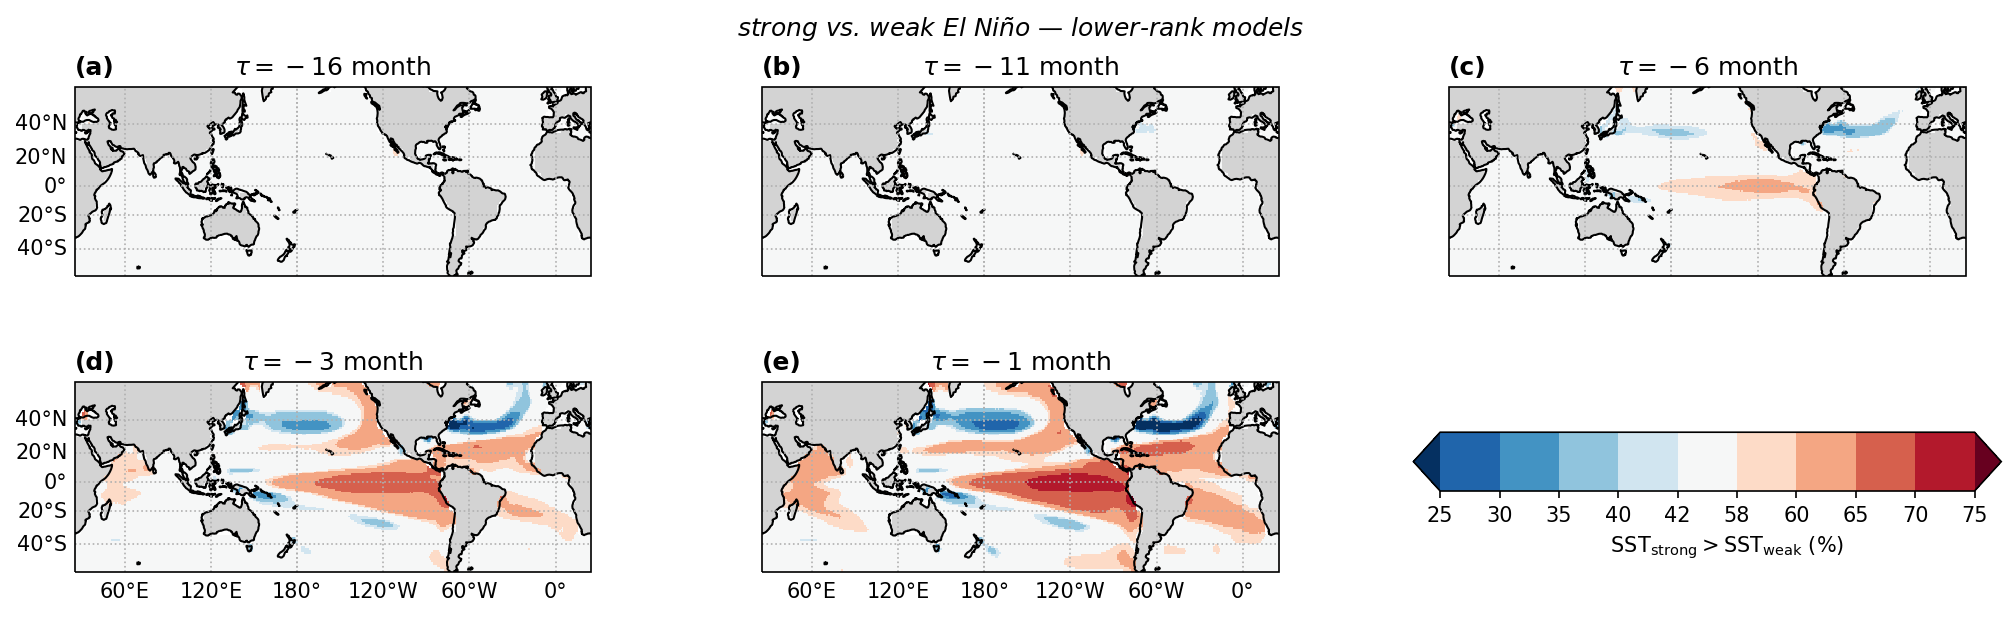

In [82]:
fig, axs, cb = vplt.map_plot(latitude[::stride], longitude[::stride], pxc_ps_lowKL[sl, ...], **kw_args)
fig.suptitle('strong vs. weak El Niño $\emdash$ lower-rank models', fontsize='large', style='italic')
cb.set_label('      $\mathrm{SST}_\mathrm{strong} > \mathrm{SST}_\mathrm{weak}$ (%)')
for n, ax in enumerate(axs.flat):
    ax.set_title(f'({chr(ord("a") + n)})', fontweight='bold', loc='left')
if EXPORT:
    fig.savefig('stats_strong_nino_low_kl.pdf', dpi=300)

##### La Niña events

In [83]:
pxc_ns_lowKL, *_ = compare_maps(idx_ns & ~mask_topk, idx_nw & ~mask_topk, stride=stride, confidence=confidence)

  0%|          | 0/100 [00:00<?, ?it/s]

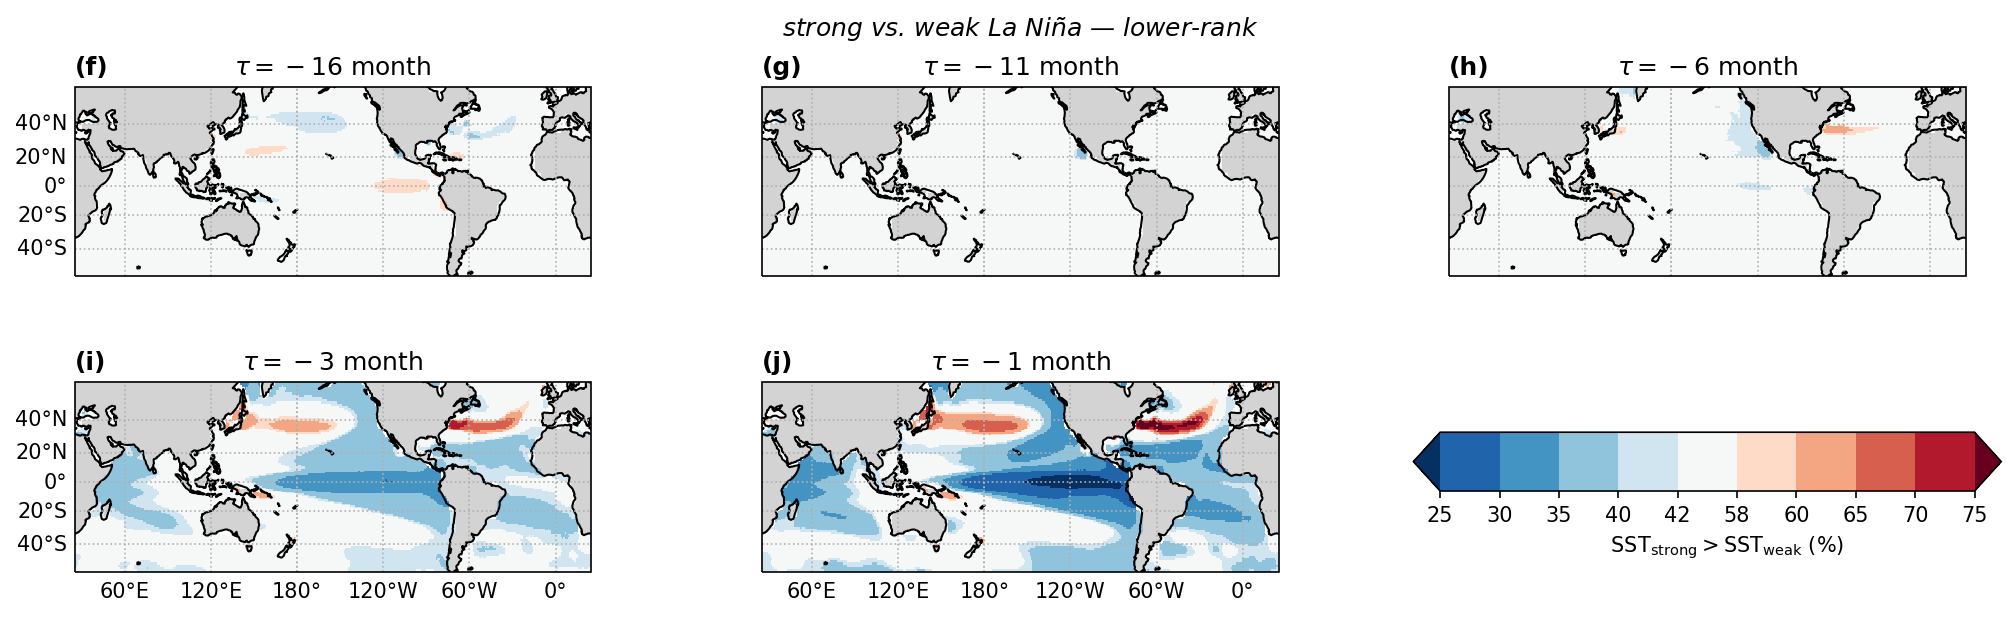

In [84]:
fig, axs, cb = vplt.map_plot(latitude[::stride], longitude[::stride], pxc_ns_lowKL[sl, ...], **kw_args)
fig.suptitle('strong vs. weak La Niña $\emdash$ lower-rank', fontsize='large', style='italic')
cb.set_label('      $\mathrm{SST}_\mathrm{strong} > \mathrm{SST}_\mathrm{weak}$ (%)')
for n, ax in enumerate(axs.flat, start=len(labels)):
    ax.set_title(f'({chr(ord("a") + n)})', fontweight='bold', loc='left')
if EXPORT:
    fig.savefig('stats_strong_nina_low_kl.pdf', dpi=300)

## Forecast composites

We first create a helper function that plots the composites from different subsets of the aggregated posterior.

In [85]:
def plot_forecast(xcs, ycs, idxs, labels, channel=0, prcs=(0, 1, 5, 25), prc_range=False, ncols=2):
    nrows = -(-len(idxs) // ncols)
    fig = plt.figure(figsize=(FIGWIDTH, nrows * 4))
    gspec = fig.add_gridspec(nrows, ncols, hspace=0.3, wspace=0.15)

    u_cmap = plt.get_cmap('YlGn', 2 * len(prcs))
    u_colors = [u_cmap(n + 2) for n in range(len(prcs))]
    l_cmap = plt.get_cmap('coolwarm', 5)
    l_colors = [l_cmap(n) for n in range(5)]

    for num, (gs, idx, label) in enumerate(zip(gspec, idxs, labels)):
        sgs = gs.subgridspec(2, 1, height_ratios=(3.5, 2), hspace=0.)
        uax, lax = sgs.subplots(sharex=True)

        xc_mean = np.mean(xcs[idx, 0, :, channel], axis=0)
        xc_prcs_lo = np.percentile(xcs[idx, 0, :, channel], prcs, axis=0)
        xc_prcs_hi = np.percentile(xcs[idx, 0, :, channel], 100 - np.array(prcs), axis=0)

        yc_mean = np.mean(ycs[idx, 0, :, channel], axis=0)
        yc_prcs_lo = np.percentile(ycs[idx, 0, :, channel], prcs, axis=0)
        yc_prcs_hi = np.percentile(ycs[idx, 0, :, channel], 100 - np.array(prcs), axis=0)

        xi = range(-len(xc_mean), 0)
        yi = range(0, len(yc_mean))

        p1a, = uax.plot(xi, xc_mean, color='darkgreen', linewidth=2, linestyle='--', zorder=2.2)
        p1b = tuple([
            uax.fill_between(xi, lo, hi, facecolor=color, alpha=0.7, zorder=2.1)
            for lo, hi, color in zip(xc_prcs_lo, xc_prcs_hi, u_colors)
        ])

        p2a, = uax.plot(yi, yc_mean, color='darkgreen', linewidth=2, zorder=2.2)
        p2b = tuple([
            uax.fill_between(yi, lo, hi, facecolor=color, alpha=0.7, zorder=2.1)
            for lo, hi, color in zip(yc_prcs_lo, yc_prcs_hi, u_colors)
        ])

        if prc_range is not False:
            p1c, = uax.plot(xi,
                            xc_prcs_hi[prc_range, :] - xc_prcs_lo[prc_range, :],
                            '-.',
                            color='tab:orange',
                            zorder=2.3)
            p2c, = uax.plot(yi,
                            yc_prcs_hi[prc_range, :] - yc_prcs_lo[prc_range, :],
                            '-.',
                            color='tab:orange',
                            zorder=2.3)
            range_label = f'{100 - 2 * prcs[prc_range]:g}% range'
        else:
            p2c = None
            range_label = ''

        if label.startswith('_'):
            uax.text(-2, -3.8, 'PAST', fontstyle='italic', ha='right', va='bottom')
            uax.text(2, -3.8, 'FUTURE', fontstyle='italic', va='bottom')
            label = label[1:]
        else:
            uax.text(-2, -3.8, 'RECONSTRUCTION', fontstyle='italic', ha='right', va='bottom')
            uax.text(2, -3.8, 'FORECAST', fontstyle='italic', va='bottom')

        uax.axhline(0, color='k', linewidth=1, linestyle=':', zorder=3)

        uax.set_title(label)
        uax.set_title('(' + chr(ord('a') + num) + ')', fontweight='bold', loc='left')
        uax.set_ylabel('Niño 3.4 SST (°C)')
        uax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        uax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
        uax.set_ylim((-4.75, 5.25))
        uax.set_xlim([xi[0] - 0.5, yi[-1] + 0.5])

        xc_p_nino_s = np.mean(xcs[idx, 0, :, channel] >= 1, axis=0)
        xc_p_nino_w = np.mean((0.5 < xcs[idx, 0, :, channel]) & (xcs[idx, 0, :, channel] < 1), axis=0)
        xc_p_nina_s = np.mean(xcs[idx, 0, :, channel] <= -1, axis=0)
        xc_p_nina_w = np.mean((-1 < xcs[idx, 0, :, channel]) & (xcs[idx, 0, :, channel] < -0.5), axis=0)
        xc_p_neutral = 1 - xc_p_nino_s - xc_p_nino_w - xc_p_nina_s - xc_p_nina_w

        yc_p_nino_s = np.mean(ycs[idx, 0, :, channel] >= 1, axis=0)
        yc_p_nino_w = np.mean((0.5 < ycs[idx, 0, :, channel]) & (ycs[idx, 0, :, channel] < 1), axis=0)
        yc_p_nina_s = np.mean(ycs[idx, 0, :, channel] <= -1, axis=0)
        yc_p_nina_w = np.mean((-1 < ycs[idx, 0, :, channel]) & (ycs[idx, 0, :, channel] < -0.5), axis=0)
        yc_p_neutral = 1 - yc_p_nino_s - yc_p_nino_w - yc_p_nina_s - yc_p_nina_w

        p3 = lax.stackplot(xi,
                           xc_p_nina_s,
                           xc_p_nina_w,
                           xc_p_neutral,
                           xc_p_nino_w,
                           xc_p_nino_s,
                           colors=l_colors,
                           alpha=0.7)
        lax.stackplot(yi, yc_p_nina_s, yc_p_nina_w, yc_p_neutral, yc_p_nino_w, yc_p_nino_s, colors=l_colors, alpha=0.7)
        lax.set_ylim((-0.15, 1.15))
        lax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        lax.set_xlabel('Lag / Lead $\\tau$ in months')
        lax.set_ylabel('p', rotation=0, va='center', ha='right')
        lax.axhline(0.5, color='k', linewidth=1, linestyle=':', zorder=3)

        if gs == gspec[0, -1]:
            prcs_label = [f'{v}\u2013{100 - v} %' for v in prcs]
            uax.legend([p2a, p1a, p2c] + [p1b[:n] for n in range(1,
                                                                 len(p1b) + 1)],
                       ['Future            ', 'Past', range_label] + prcs_label,
                       loc='upper left',
                       bbox_to_anchor=(1, 1))
            lax.legend(reversed(p3), ('strong El Niño', 'weak El Niño', 'neutral', 'weak La Niña', 'strong La Niña'),
                       loc='center left',
                       bbox_to_anchor=(1, 0.5))

        for ax in (uax, lax):
            ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
            ax.grid(linestyle=':')
            ax.axvline(0, color='k', linewidth=0.7, zorder=3)
            ax.tick_params(axis='both', which='both', right=True, top=True, direction='in')

    fig.subplots_adjust()
    return fig

### VAE composites

We analyze the corresponding composite in the ENSO prediction of the VAE wrt to the type and strength of the ENSO events.

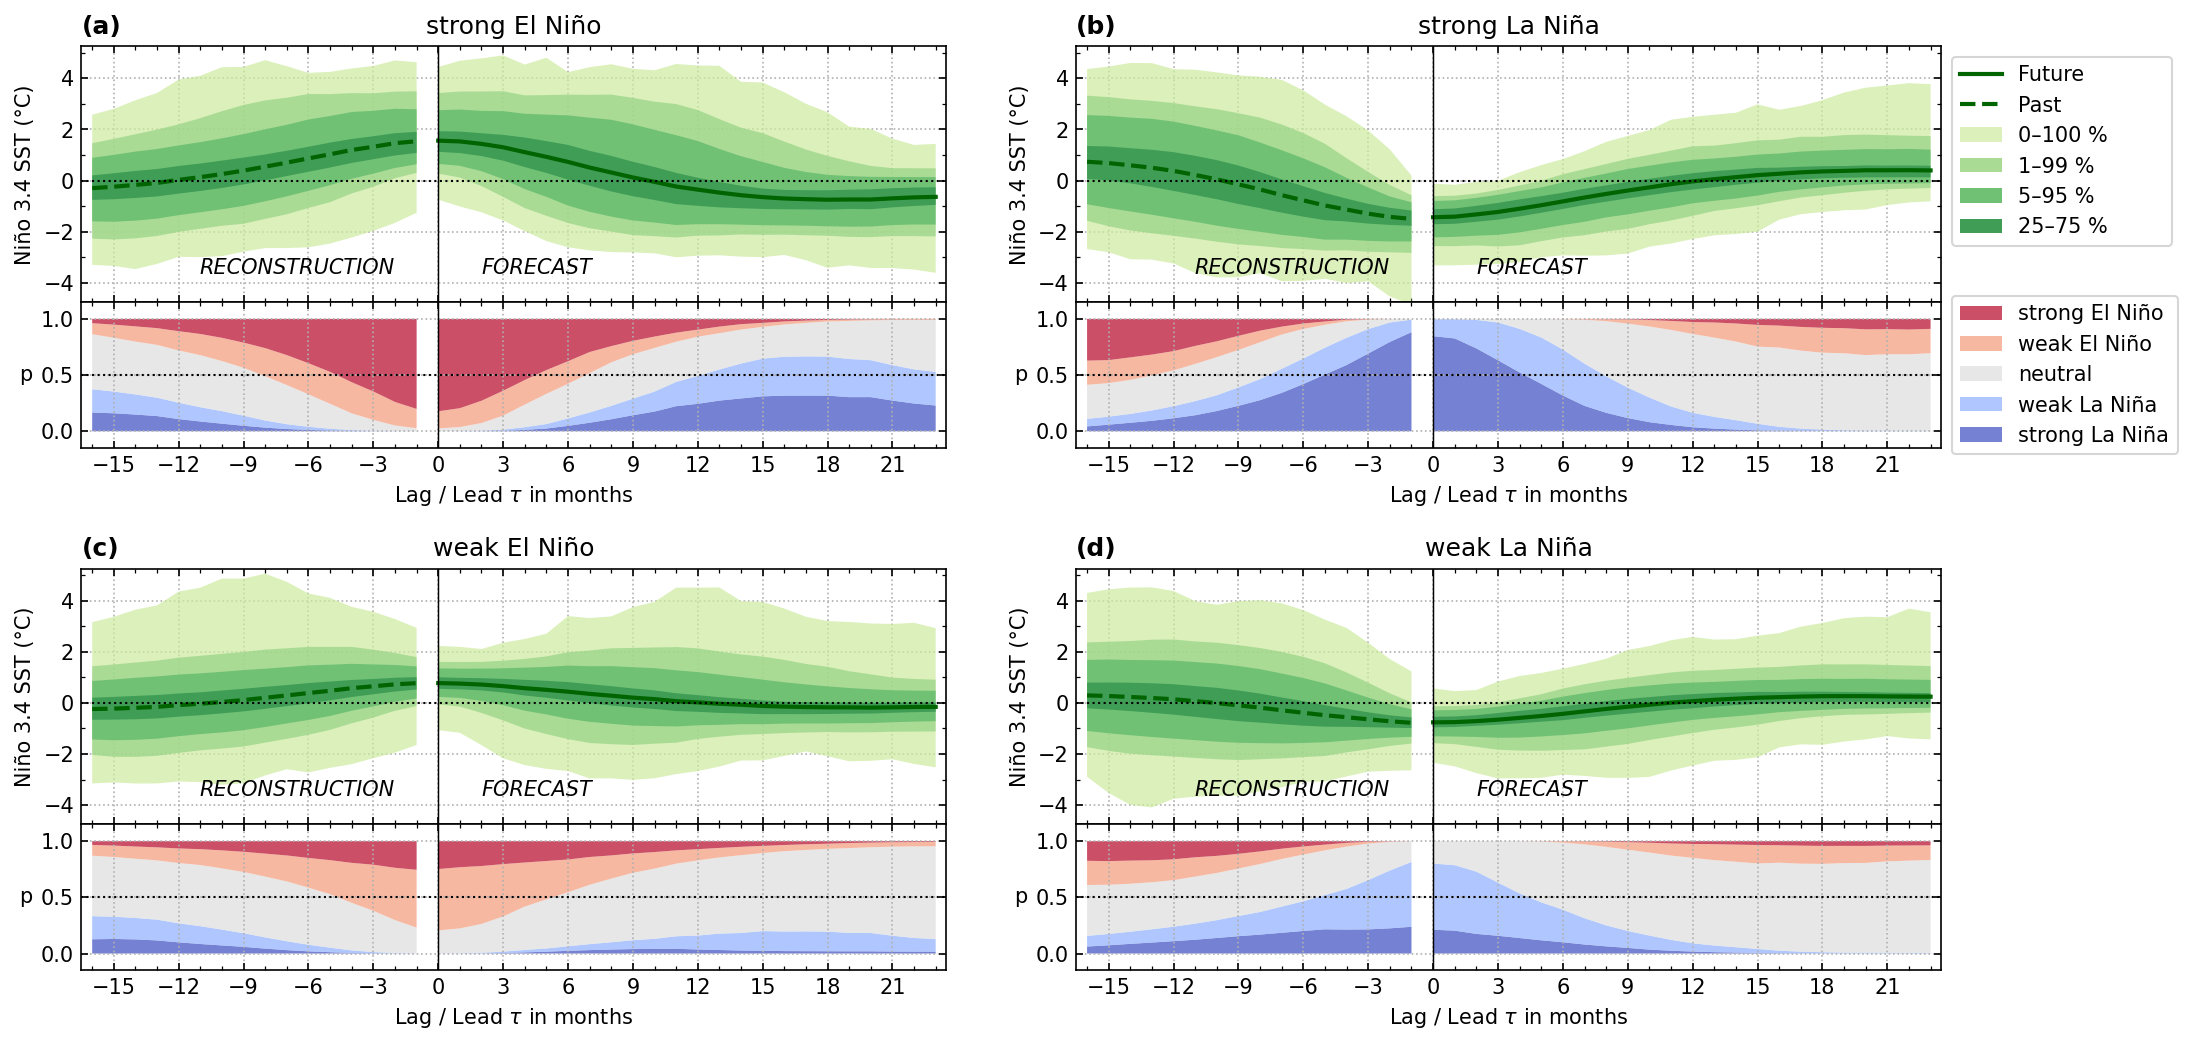

In [86]:
idxs = idx_ps, idx_ns, idx_pw, idx_nw
labels = 'strong El Niño', 'strong La Niña', 'weak El Niño', 'weak La Niña'
fig = plot_forecast(xcs, ycs, idxs, labels)
if EXPORT:
    fig.savefig('enso_forecast.pdf', bbox_inches='tight')

### VAE composites vs. KL

Then we obtain ENSO composites from the posterior that is aggregated from a certain subset of CMIP models only. We distinguish between CMIP models that have a high/low KL divergence.

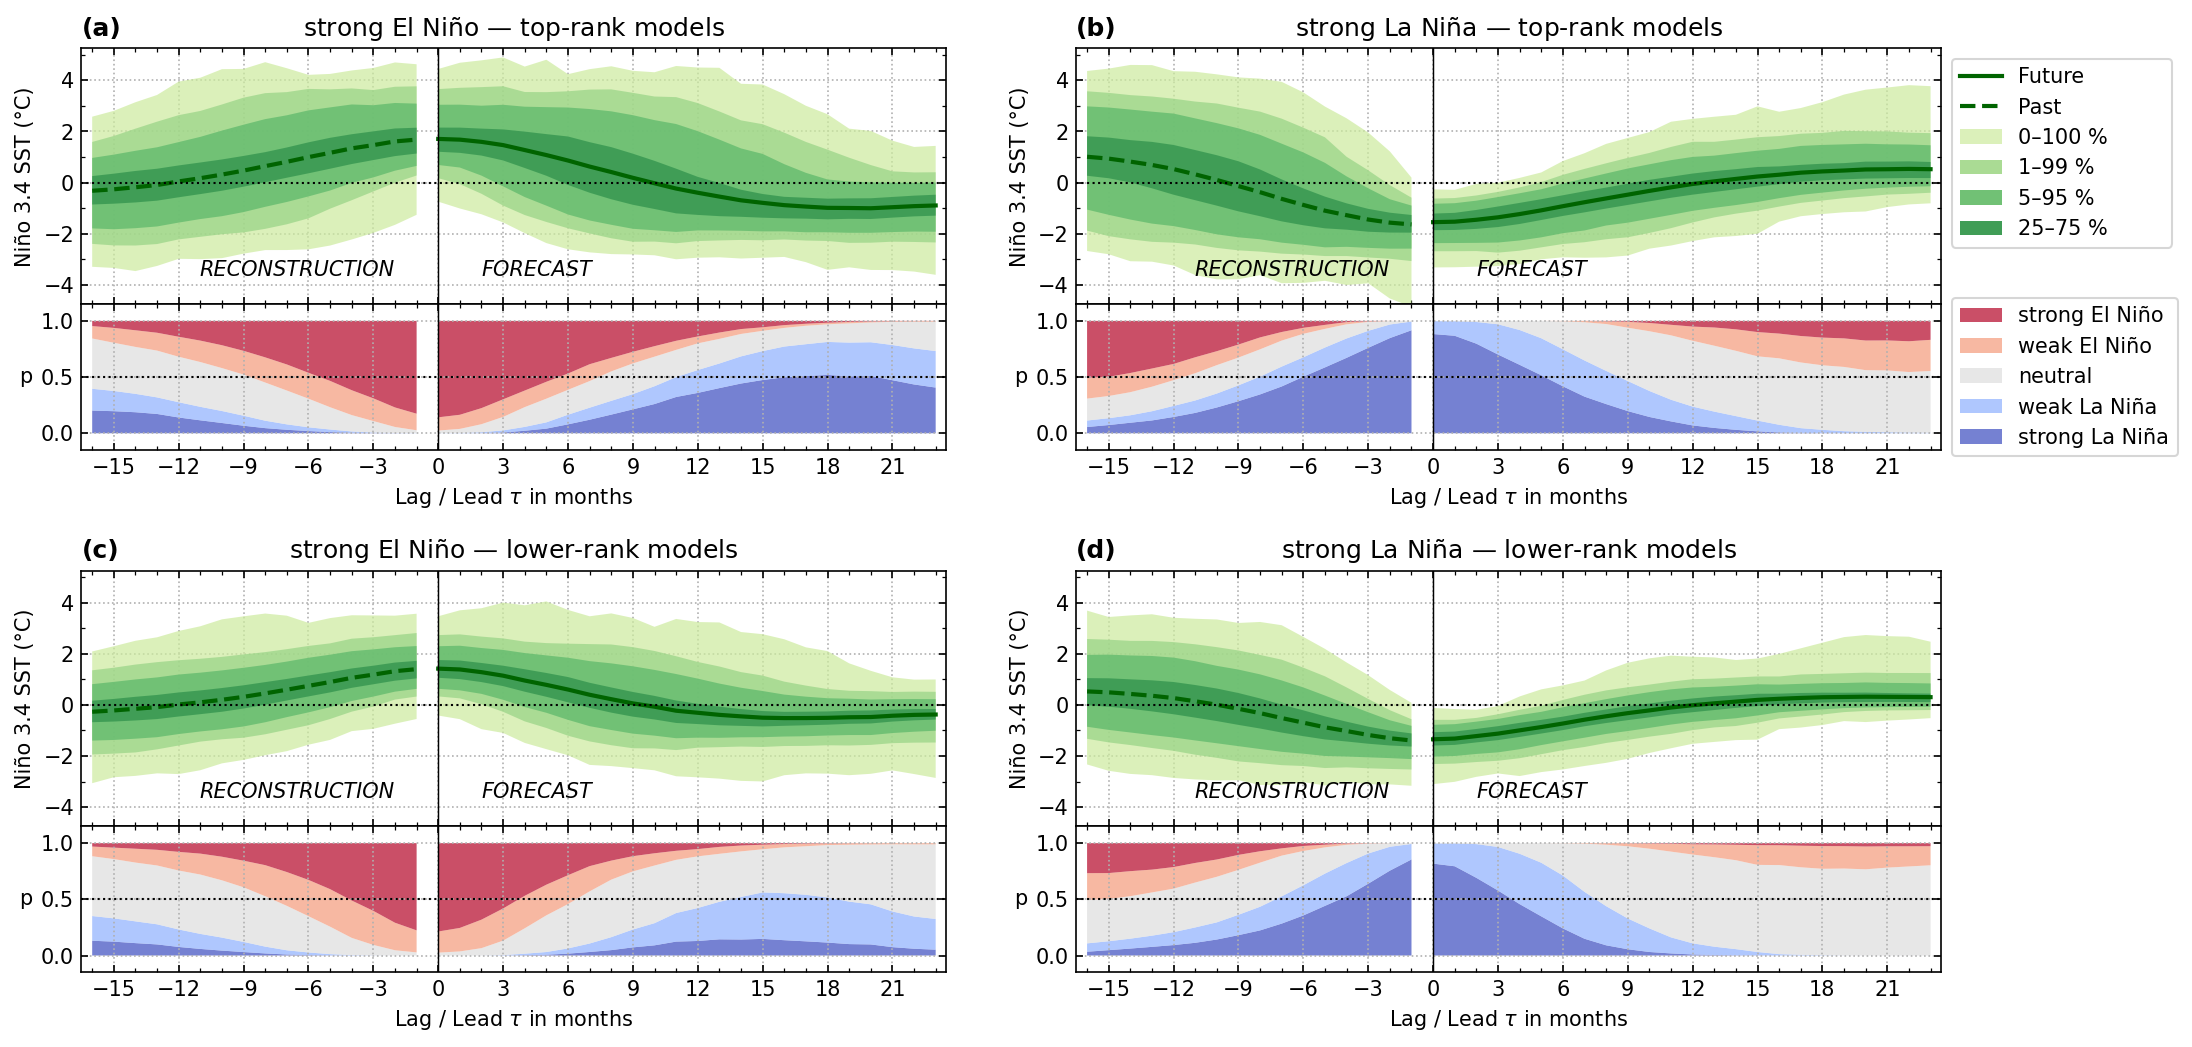

In [87]:
idxs = idx_ps * mask_topk, idx_ns * mask_topk, idx_ps * ~mask_topk, idx_ns * ~mask_topk
labels = [
    'strong El Niño $\emdash$ top-rank models',
    'strong La Niña $\emdash$ top-rank models',
    'strong El Niño $\emdash$ lower-rank models',
    'strong La Niña $\emdash$ lower-rank models',
]
fig = plot_forecast(xcs, ycs, idxs, labels)
if EXPORT:
    fig.savefig('enso_forecast_kl.pdf', bbox_inches='tight')

### ERSST composites

We obtain ENSO composites of the observational data and compare it with the VAE output (reconstruction and prediction).

In [88]:
r = ref_gen.repeat_samples
target2_xcs = np.concatenate([targets['decoder'][::r, ...] for _, targets in ref_gen])
target2_ycs = np.concatenate([targets['prediction'][::r, ...] for _, targets in ref_gen])
xcs2, ycs2 = model.predict(ref_gen)

In [89]:
nino_events_idx = np.array([np.searchsorted(target_time2[::r], np.datetime64(f'{event}-12')) for event in nino_events])
nina_events_idx = np.array([np.searchsorted(target_time2[::r], np.datetime64(f'{event}-12')) for event in nina_events])

nino_events_idx_r = np.concatenate([nino_events_idx * r + s for s in range(r)])
nina_events_idx_r = np.concatenate([nina_events_idx * r + s for s in range(r)])

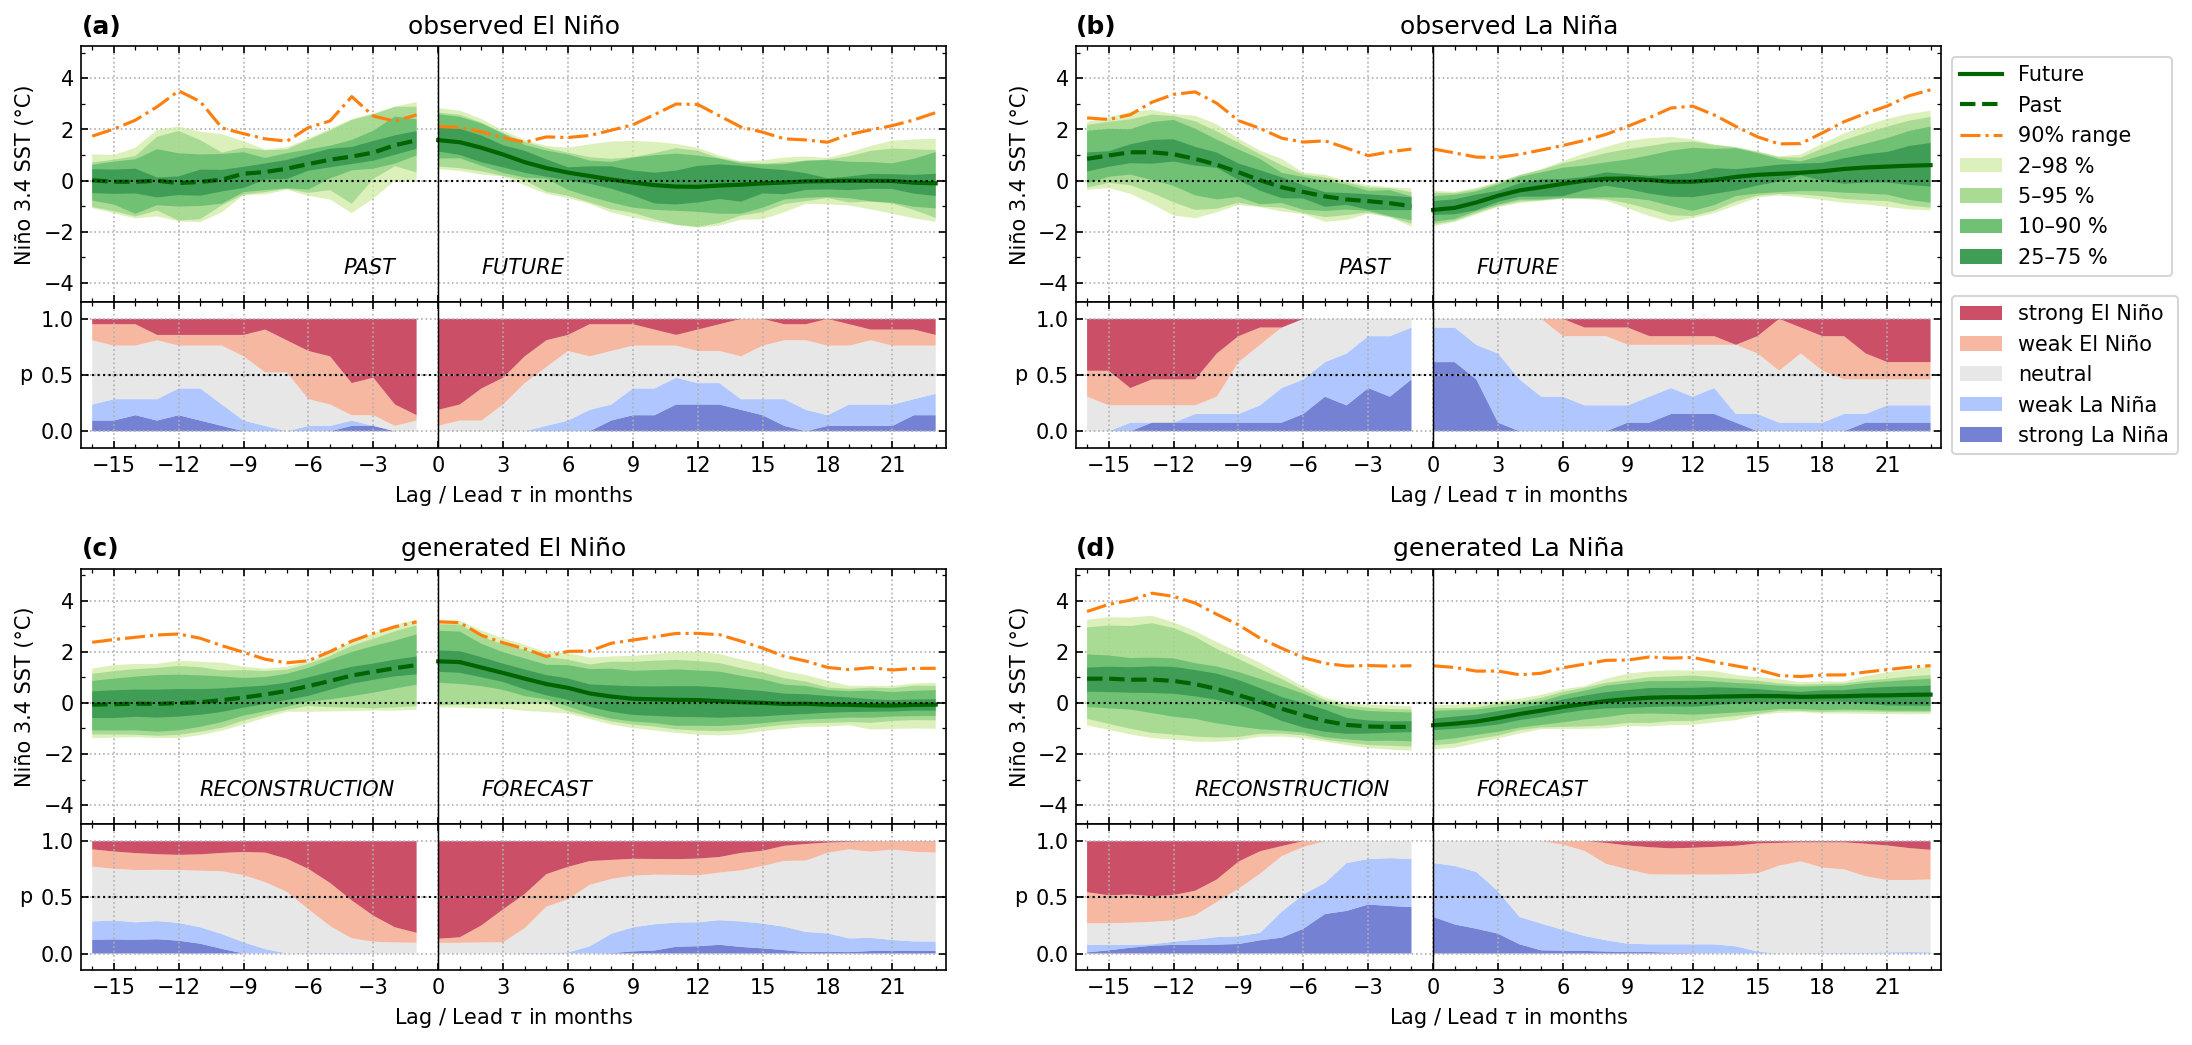

In [90]:
N = len(target2_xcs)
idxs = nino_events_idx, nina_events_idx, nino_events_idx_r + N, nina_events_idx_r + N
labels = '_observed El Niño', '_observed La Niña', 'generated El Niño', 'generated La Niña'
fig = plot_forecast(np.concatenate([target2_xcs, xcs2]),
                    np.concatenate([target2_ycs, ycs2]),
                    idxs,
                    labels,
                    prc_range=1,
                    prcs=(2, 5, 10, 25))

if EXPORT:
    fig.savefig('ERSST_composites.pdf', bbox_inches='tight')

### CMIP composites

We obtain CMIP composites from CMIP samples that correspond to the different ENSO clusters identified by the VAE.

In [91]:
channel = [0]
target_xcs = np.concatenate([targets['decoder'][..., channel] for _, targets in fit_gen])
target_ycs = np.concatenate([targets['prediction'][..., channel] for _, targets in fit_gen])

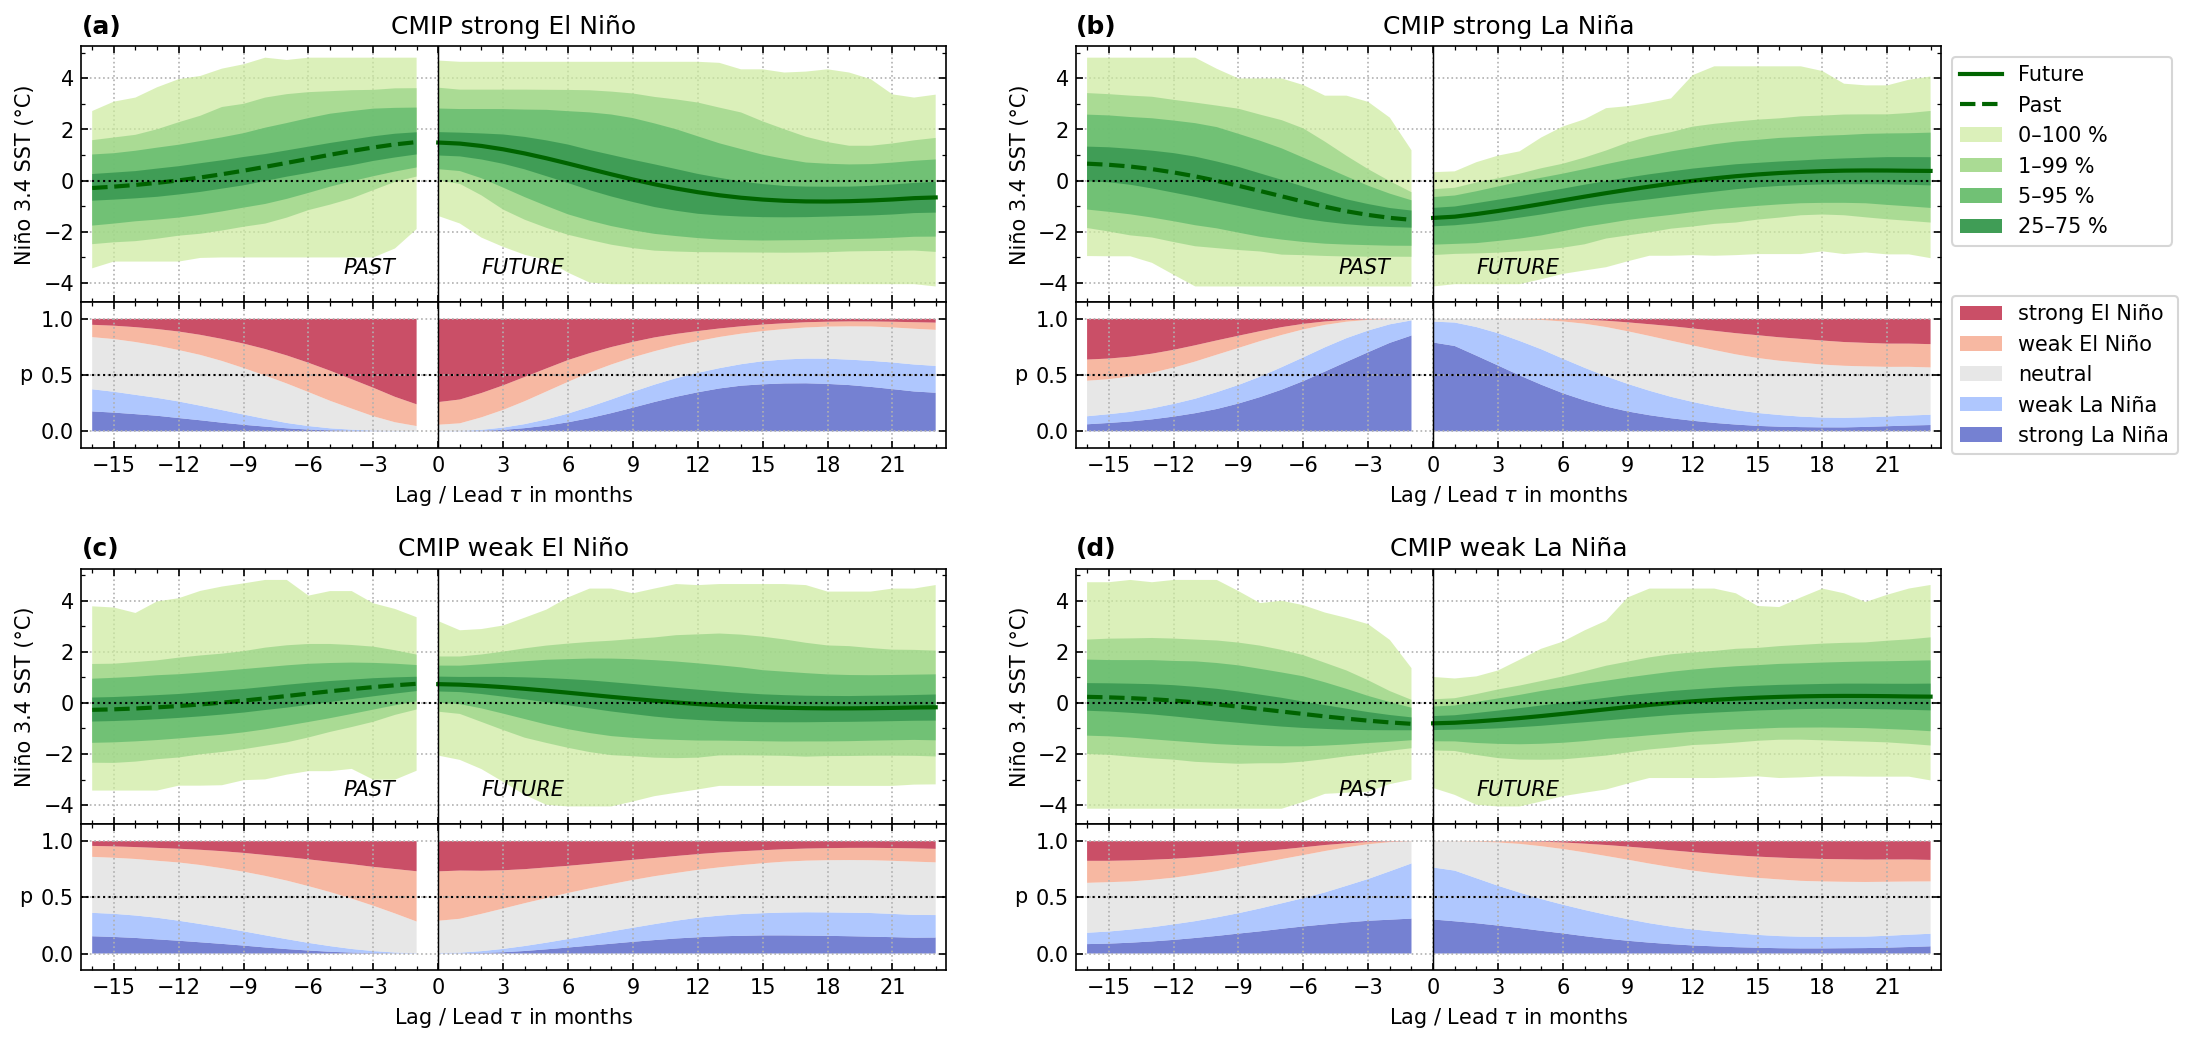

In [92]:
idxs = idx_ps, idx_ns, idx_pw, idx_nw
labels = '_CMIP strong El Niño', '_CMIP strong La Niña', '_CMIP weak El Niño', '_CMIP weak La Niña'
fig = plot_forecast(target_xcs, target_ycs, idxs, labels)
if EXPORT:
    fig.savefig('CMIP_composites.pdf', bbox_inches='tight')

## ENSO asymmetry

We finally analyze the ENSO asymmetry. Since the asymmetry and the ENSO strength both depend on the choosen threshold, we vary the threshold for the selection of El Niño and La Niña events.

In [93]:
levels = np.arange(0.1, 2, 0.15)

In [94]:
r = fit_gen.repeat_samples
channel = 0
lags = slice(-3, None)
target_decoder = [targets['decoder'][::r, 0, :, channel] for _, targets in fit_gen]
target_decoder = np.concatenate(target_decoder)
target_decoder = target_decoder[:, lags].mean(axis=-1)
target_decoder = target_decoder.reshape(len(dataset), -1)

lag = -1
target_xcs = [targets['decoder'][::r, 0, lag, :] for _, targets in fit_gen]
target_xcs = np.concatenate(target_xcs)
target_pcs = target_xcs[..., pc_idx] / pc_scales * pc_correction
target_pcs = target_pcs.reshape(len(dataset), -1, *target_pcs.shape[1:])

In [95]:
idx_sorted = np.argsort(dataset_names)
labels = list(sorted(dataset_names))
target_decoder = target_decoder[idx_sorted, ...]
target_pcs = target_pcs[idx_sorted, ...]

For reference, we also add observational ERSST data of the same time interval.

In [96]:
r = ref_gen.repeat_samples
target2_decoder = [targets['decoder'][::r, 0, :, channel] for _, targets in ref_gen]
target2_decoder = np.concatenate(target2_decoder)
target2_decoder = target2_decoder[:, lags].mean(axis=-1)

target2_pcs = [targets['decoder'][::r, 0, lag, :] for _, targets in ref_gen]
target2_pcs = np.concatenate(target2_pcs)
target2_pcs = target2_pcs[..., pc_idx] / pc_scales * pc_correction

num = target_decoder.shape[-1]
target_decoder = np.append(target_decoder, target2_decoder[None, :num], axis=0)
target_pcs = np.append(target_pcs, target2_pcs[None, :num, ...], axis=0)
labels.append('obs. ERSST')

We obtain the average of the EOFs in the regions of interest that we can later on project the PCs onto.

In [97]:
ep_eofs = ieof_stack[:, (-5 <= latitude) & (latitude <= 5), :][..., (220 <= longitude) & (longitude <= 280)]
wp_eofs = ieof_stack[:, (-5 <= latitude) & (latitude <= 5), :][..., (140 <= longitude) & (longitude <= 200)]
nino_eofs = ieof_stack[:, (-5 <= latitude) & (latitude <= 5), :][..., (190 <= longitude) & (longitude <= 240)]
ep_eofs = np.nanmean(ep_eofs, axis=(-2, -1))
wp_eofs = np.nanmean(wp_eofs, axis=(-2, -1))
nino_eofs = np.nanmean(nino_eofs, axis=(-2, -1))

First, we vary the threshold for the VAE.

In [98]:
s = np.s_[:, 0, lag, :]
xc_nino = np.tensordot(pcs[s], nino_eofs, axes=1)
xc_ep = np.tensordot(pcs[s], ep_eofs, axes=1)
xc_wp = np.tensordot(pcs[s], wp_eofs, axes=1)

xc_values = []
yc_values = []
xc_values_topk = []
yc_values_topk = []
for level in levels:
    idxp = level < z_proj
    idxn = z_proj < -level
    asym = (np.mean(xc_ep[idxp]) + np.mean(xc_ep[idxn])) - (np.mean(xc_wp[idxp]) + np.mean(xc_wp[idxn]))
    xc_values.append(np.mean(xc_nino[idxp]))
    yc_values.append(asym)

    idxp_tk = idxp & ~mask_topk
    idxn_tk = idxn & ~mask_topk
    asym = (np.mean(xc_ep[idxp_tk]) + np.mean(xc_ep[idxn_tk])) - (np.mean(xc_wp[idxp_tk]) + np.mean(xc_wp[idxn_tk]))
    xc_values_topk.append(np.mean(xc_nino[idxp_tk]))
    yc_values_topk.append(asym)

Then, we vary the threshold for the observed data and the individual CMIP runs.

In [99]:
target_xc_nino = np.tensordot(target_pcs, nino_eofs, axes=1)
target_xc_ep = np.tensordot(target_pcs, ep_eofs, axes=1)
target_xc_wp = np.tensordot(target_pcs, wp_eofs, axes=1)

target_xc_values = []
target_yc_values = []
for dec, nino, ep, wp in zip(target_decoder, target_xc_nino, target_xc_ep, target_xc_wp):
    buf_x = []
    buf_y = []
    for level in levels:
        idxp = level < dec
        idxn = dec < -level
        if (np.mean(idxp) > 0.025) & (np.mean(idxn) > 0.025):
            asym = (np.mean(ep[idxp]) + np.mean(ep[idxn])) - (np.mean(wp[idxp]) + np.mean(wp[idxn]))
            buf_x.append(np.mean(nino[idxp]))
            buf_y.append(asym)

    target_xc_values.append(buf_x)
    target_yc_values.append(buf_y)

We further concatenate all CMIP runs and obtain values for the CMIP ensemble.

In [100]:
s = np.index_exp[:len(dataset), ...]
shape = (-1, ) + target_xc_nino.shape[2:]

target_xc_nino_ens = target_xc_nino[s].reshape(shape)
target_xc_ep_ens = target_xc_ep[s].reshape(shape)
target_xc_wp_ens = target_xc_wp[s].reshape(shape)
target_decoder_ens = target_decoder[s].reshape(-1, *target_decoder.shape[2:])

target_xc_ens = []
target_yc_ens = []
for level in levels:
    idxp = level < target_decoder_ens
    idxn = target_decoder_ens < -level
    asym = (np.mean(target_xc_ep_ens[idxp]) + np.mean(target_xc_ep_ens[idxn]))
    asym -= (np.mean(target_xc_wp_ens[idxp]) + np.mean(target_xc_wp_ens[idxn]))
    target_xc_ens.append(np.mean(target_xc_nino_ens[idxp]))
    target_yc_ens.append(asym)

Plot results

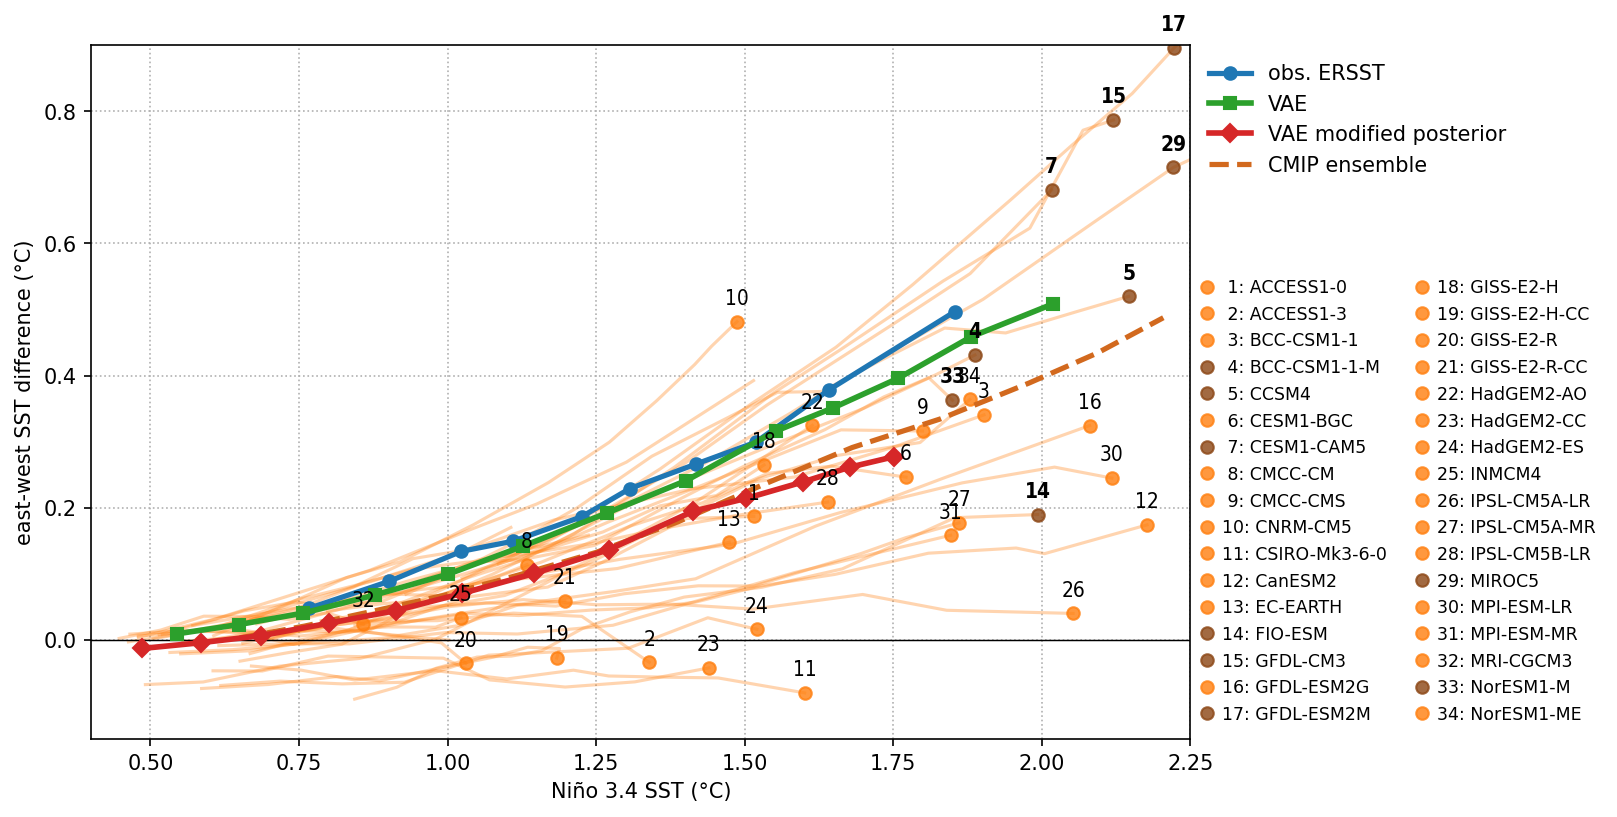

In [101]:
fig, ax = plt.subplots(1, figsize=(FIGWIDTH / 3 * 2, FIGWIDTH / 3))

xlim = [0.4, 2.25]
ylim = [-0.15, 0.9]

p_ps = np.sum(idx_ps.reshape(len(dataset), -1), axis=1) / np.sum(idx_ps)
p_ns = np.sum(idx_ns.reshape(len(dataset), -1), axis=1) / np.sum(idx_ns)

idx_sel = np.zeros(len(dataset))
idx_sel[idx_topk] = 1
idx_sel = idx_sel[idx_sorted]

p1 = []
for xv, yv in zip(target_xc_values[len(dataset):], target_yc_values[len(dataset):]):
    p1 += ax.plot(xv, yv, 'o-', color='tab:blue', linewidth=2.5, zorder=5.2)

p2a = ax.plot(xc_values, yc_values, 's-', color='tab:green', linewidth=2.7, zorder=5.3)
p2b = ax.plot(xc_values_topk, yc_values_topk, 'D-', color='tab:red', linewidth=2.7, zorder=5.3)

p3 = ax.plot(target_xc_ens, target_yc_ens, '--', color='chocolate', linewidth=2.5, zorder=5.1)

for xv, yv in zip(target_xc_values[:len(dataset)], target_yc_values[:len(dataset)]):
    ax.plot(xv, yv, '-', color='tab:orange', alpha=0.33, zorder=1.9)

idx = -1
p4 = []
p4_labels = []
show_labels, show_idxs = np.unique(labels[:len(dataset)], return_index=True)  # remove duplicate runs
for n, (idx, label) in enumerate(zip(show_idxs, show_labels), start=1):
    xv = target_xc_values[idx]
    yv = target_yc_values[idx]
    pos = min(np.searchsorted(xv, xlim[1], side='left'), len(xv)) - 1
    if idx_sel[idx]:
        color = 'saddlebrown'
        weight = 'bold'
    else:
        color = 'tab:orange'
        weight = 'normal'
    p4 += ax.plot(xv[pos], yv[pos], 'o', color=color, alpha=0.8, zorder=2.2)
    ax.text(xv[pos],
            yv[pos] + 0.02,
            f'{n}',
            va='bottom',
            ha='center',
            weight=weight,
            stretch='ultra-condensed',
            zorder=6.0)
    p4_labels.append(f'{n: >2}: {label}')

ax.set_xlabel('Niño 3.4 SST (°C)')
ax.set_ylabel('east-west SST difference (°C)')
ax.axhline(0, linestyle='-', color='k', linewidth=0.7)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

leg = ax.legend(p1 + p2a + p2b + p3,
                labels[len(dataset):] + ['VAE', 'VAE modified posterior', 'CMIP ensemble'],
                loc='upper left',
                ncol=1,
                bbox_to_anchor=(1, 1),
                frameon=False)

ax.legend(p4,
          p4_labels,
          loc='lower left',
          ncol=2,
          bbox_to_anchor=(1, 0),
          frameon=False,
          fontsize='small',
          handlelength=0.1)
ax.add_artist(leg)
ax.grid(which='major', axis='both', linestyle=':')
if EXPORT:
    fig.savefig('enso_asymmetry.pdf')